# Import

In [ ]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import seaborn as sns
from matplotlib.colors import ListedColormap

sys.path.append('./src')
import BNMPy

network_file = '../input_files/Palma2021.txt' # contains the phenotype nodes
network_file_no_phenotype = '../input_files/Palma2021_no_phenotype.txt' # no phenotype nodes

drugs = [
"Venetoclax",
"Entospletinib",
"Ibrutinib",
"Trametinib",
"Selumetinib",
"Midostaurin",
]

drug2target = {
    'Venetoclax': ['BCL2'], 
    'Ibrutinib': ['BTK'], 
    'Entospletinib': ['SYK'],
    'Trametinib': ['MAP2K1','MAP2K2'],
    'Selumetinib': ['MAP2K1','MAP2K2'],
    'Midostaurin': ['FLT3','KIT'],
    }

# BeatAML data

This follows the exact approach from the BeatAML2 manuscript   
(see https://github.com/biodev/beataml2_manuscript/blob/main/R/preprocess.R, function `mutation.only.dataset()`):

1. Filter clinical data: Only samples with `manuscript_dnaseq == 'yes'`
2. Create binary mutation matrix: Rows = patients (ptid), Columns = genes, Values = 1 (mutation present) or 0 (absent)
3. Add consensus annotations: Override with manual annotations from clinical file for:
   - NPM1 (from NPM1 column: positive = 1)
   - FLT3_ITD (from FLT3-ITD column: positive = 1)
   - RUNX1 (from RUNX1 column: not NA = 1)
   - ASXL1 (from ASXL1 column: not NA = 1)
   - TP53 (from TP53 column: not NA = 1)

In [182]:
# BeatAML data
drug_response = pd.read_csv("https://media.githubusercontent.com/media/biodev/beataml2.0_data/main/beataml_probit_curve_fits_v4_dbgap.txt", sep='\t')
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")

# Filter clinical data to those with DNA sequencing
dna_clin = clinical[clinical['manuscript_dnaseq'] == 'yes'].copy()

# Merge with clinical data 
dna_clin['ptid'] = 'pt' + dna_clin['dbgap_subject_id'].astype(str)
muts_merged = pd.merge(
    dna_clin[['ptid', 'dbgap_dnaseq_sample', 'cohort', 'NPM1', 'FLT3-ITD', 'RUNX1', 'ASXL1', 'TP53']],
    mutations,
    left_on='dbgap_dnaseq_sample',
    right_on='dbgap_sample_id',
    how='inner'
)
# Create binary mutation matrix (patient x gene): if a patient has any mutation in a gene, mark as 1
muts_merged['value'] = 1
mutation_matrix = muts_merged.pivot_table(
    index='ptid',
    columns='symbol',
    values='value',
    aggfunc='max',  # If multiple mutations in same gene, still just 1
    fill_value=0
)
# Add manual annotations from clinical data (NPM1, FLT3-ITD, RUNX1, ASXL1, TP53)
manual_muts = dna_clin.set_index('ptid')[['NPM1', 'FLT3-ITD', 'RUNX1', 'ASXL1', 'TP53']].copy()
manual_muts['NPM1'] = (manual_muts['NPM1'] == 'positive').astype(int)
manual_muts['FLT3_ITD'] = (manual_muts['FLT3-ITD'] == 'positive').astype(int)
manual_muts['RUNX1'] = manual_muts['RUNX1'].notna().astype(int)
manual_muts['ASXL1'] = manual_muts['ASXL1'].notna().astype(int)
manual_muts['TP53'] = manual_muts['TP53'].notna().astype(int)
manual_muts = manual_muts[['NPM1', 'FLT3_ITD', 'RUNX1', 'ASXL1', 'TP53']]

# some patients in clinical file don't have WES mutations
missing_patients = list(set(manual_muts.index) - set(mutation_matrix.index))
if missing_patients:
    missing_df = pd.DataFrame(0, index=missing_patients, columns=mutation_matrix.columns)
    mutation_matrix = pd.concat([mutation_matrix, missing_df])

# Add missing gene columns if needed
for gene in ['FLT3', 'FLT3_ITD', 'NPM1', 'RUNX1', 'ASXL1', 'TP53']:
    if gene not in mutation_matrix.columns:
        mutation_matrix[gene] = 0

# Override with consensus annotations for NPM1, RUNX1, ASXL1, TP53
# For FLT3_ITD: update the FLT3_ITD column with clinical consensus
common_patients = list(set(manual_muts.index) & set(mutation_matrix.index))
for gene in ['NPM1', 'FLT3_ITD', 'RUNX1', 'ASXL1', 'TP53']:
    mutation_matrix.loc[common_patients, gene] = manual_muts.loc[common_patients, gene]

# Keep any patient with FLT3 from WES OR FLT3_ITD from clinical
mutation_matrix['FLT3_combined'] = ((mutation_matrix['FLT3'] == 1) | (mutation_matrix['FLT3_ITD'] == 1)).astype(int)

print(f"Mutation matrix shape: {mutation_matrix.shape}")

# mutation frequencies as percentages
mut_freq = mutation_matrix.sum().sort_values(ascending=False)
mut_pct = (mut_freq / len(mutation_matrix) * 100).round(1)
print(f"\nTop 20 most frequent mutations:")
for gene, pct in mut_pct.head(20).items():
    print(f"  {gene}: {pct}%")

# dbgap_sample_id -> ptid -> mutation profile
sample_to_ptid = dna_clin[['dbgap_dnaseq_sample', 'ptid', 'dbgap_subject_id', 'cohort']].copy()
sample_to_ptid.rename(columns={'dbgap_dnaseq_sample': 'dbgap_sample_id'}, inplace=True)

Mutation matrix shape: (713, 2989)

Top 20 most frequent mutations:
  FLT3_combined: 29.7%
  NPM1: 25.8%
  FLT3_ITD: 22.4%
  DNMT3A: 21.6%
  NRAS: 14.3%
  TET2: 13.7%
  RUNX1: 13.5%
  IDH2: 13.3%
  SRSF2: 12.2%
  ASXL1: 10.8%
  TP53: 10.7%
  FLT3: 9.0%
  STAG2: 7.9%
  IDH1: 7.6%
  WT1: 7.3%
  BCOR: 5.9%
  CEBPA: 5.8%
  U2AF1: 5.3%
  KRAS: 5.0%
  PTPN11: 4.9%


In [183]:
# Create dataset with drug response and mutations
sample_mutations = {}
for ptid in mutation_matrix.index:
    mutated_genes = mutation_matrix.loc[ptid][mutation_matrix.loc[ptid] == 1].index.tolist()
    # Filter to only model genes
    # mutated_genes_in_model = [g for g in mutated_genes if g in pbn.nodeDict.keys()]
    mutated_genes_in_model = [g for g in mutated_genes if g in ['FLT3_ITD', 'NPM1', 'DNMT3A']]
    sample_mutations[ptid] = set(mutated_genes_in_model)

# Create mutation profile mapping
mutation_profiles = []
for _, row in sample_to_ptid.iterrows():
    ptid = row['ptid']
    if ptid in sample_mutations:
        mutation_profiles.append({
            'dbgap_sample_id': row['dbgap_sample_id'],
            'ptid': ptid,
            'mutation_profile': sample_mutations[ptid]
        })

mutation_profile_df = pd.DataFrame(mutation_profiles)

# Merge with drug response data
drug_response_merged = pd.merge(
    mutation_profile_df,
    drug_response,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample',
    how='inner'
)

# Filter for selected drugs of interest
df = drug_response_merged[drug_response_merged['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()

# Merge cohort information
df = pd.merge(df, sample_to_ptid[['dbgap_sample_id', 'cohort']], on='dbgap_sample_id', how='left')

print(f"dataset: {len(df)} records")
print(f"Drugs: {sorted(df['inhibitor'].unique())}")

dataset: 2383 records
Drugs: ['Entospletinib (GS-9973)', 'Ibrutinib (PCI-32765)', 'Midostaurin', 'Selumetinib (AZD6244)', 'Trametinib (GSK1120212)', 'Venetoclax']


In [29]:
df

,dbgap_sample_id,ptid,mutation_profile,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,type,status,paper_inclusion,...,ic10,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type,cohort
0,BA3039D,pt2207,{},2207,BA3039D,NaN,Ibrutinib (PCI-32765),single-agent,train/test,True,...,10.000000,10.000000,10.000000,10.000000,10.000000,275.085653,True,False,increasing,Waves1+2
1,BA3172D,pt2751,{},2751,BA3172D,NaN,Ibrutinib (PCI-32765),single-agent,train/test,True,...,4.007967,10.000000,10.000000,10.000000,10.000000,275.704046,True,False,decreasing,Waves3+4
2,BA3172D,pt2751,{},2751,BA3172D,NaN,Midostaurin,single-agent,train/test,True,...,0.013700,0.061417,1.051243,10.000000,10.000000,168.625182,False,False,decreasing,Waves3+4
3,BA3172D,pt2751,{},2751,BA3172D,NaN,Selumetinib (AZD6244),single-agent,train/test,True,...,0.013700,0.371165,10.000000,10.000000,10.000000,212.700908,True,False,decreasing,Waves3+4
4,BA3172D,pt2751,{},2751,BA3172D,NaN,Trametinib (GSK1120212),single-agent,train/test,True,...,0.013700,0.013700,0.557860,10.000000,10.000000,147.067312,False,False,decreasing,Waves3+4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Ibrutinib (PCI-32765),single-agent,train/test,True,...,0.013700,0.917243,10.000000,10.000000,10.000000,218.715266,True,False,decreasing,Waves3+4
2632,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Midostaurin,single-agent,train/test,True,...,0.035519,10.000000,10.000000,10.000000,10.000000,271.662263,True,False,increasing,Waves3+4
2633,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Selumetinib (AZD6244),single-agent,train/test,True,...,10.000000,10.000000,10.000000,10.000000,10.000000,284.545522,True,False,decreasing,Waves3+4
2634,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Trametinib (GSK1120212),single-agent,train/test,True,...,4.394901,3.974823,3.555000,3.179523,2.875606,44.916043,False,False,increasing,Waves3+4


# Augmenting and optimizing the model
## Create exp data

The 8 mutation profiles (FLT3-ITD, NPM1, DNMT3A and their combinations) for 3 drugs: Venetoclax, Ibrutinib, Entospletinib.

In [41]:
# mutation class
classification = pd.read_csv("../input_files/Palma_class.csv")
gene_to_class = dict(zip(classification['symbol'], classification['class']))
gene_to_class

{'AKT1': 'oncogene',
 'BCL2': 'oncogene',
 'CCND1': 'oncogene',
 'CDKN2A': 'TSG',
 'CEBPA': 'TSG',
 'DNMT3A': 'TSG',
 'ETV6': 'TSG',
 'FBXW7': 'TSG',
 'FLT3': 'oncogene',
 'GSK3B': 'oncogene',
 'HOXA9': 'oncogene',
 'MAPK1': 'oncogene',
 'MEIS1': 'oncogene',
 'MYC': 'oncogene',
 'NPM1': 'TSG',
 'SOX4': 'oncogene',
 'STAT5A': 'oncogene',
 'TP53': 'TSG',
 'ATM': 'TSG',
 'CDKN1B': 'TSG',
 'CYCS': 'TSG',
 'MTOR': 'oncogene',
 'NRAS': 'oncogene',
 'PIK3CA': 'oncogene',
 'ROS1': 'oncogene'}

In [108]:
def create_experimental_data(df, cohort='Waves1+2',
                            mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'], 
                            inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
                            drug2target=None,
                            output_file='beataml_experiments.csv'):
    """
    Create experimental data CSV from BeatAML drug response data.
    
    Parameters:
    - df: DataFrame with mutation_profile, inhibitor, and auc columns
    - cohort: 'Waves1+2' or 'Waves3+4' or None
    - mutation_genes: List of genes
    - inhibitors: List of drug names
    - output_file: Output CSV filename
    
    Note: Oncogenes become Stimuli, TSGs become Inhibitors based on gene_to_class
    """
    
    # Drug to target mapping
    if drug2target is None:
        drug2target = {
            'Venetoclax': ['BCL2'], 
            'Ibrutinib': ['BTK'], 
            'Entospletinib': ['SYK'],
            'Trametinib': ['MAP2K1','MAP2K2'],
            'Selumetinib': ['MAP2K1','MAP2K2'],
            'Midostaurin': ['FLT3','KIT'],
            }
    
    # Normalize profile text for comparison
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\\{\\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return set(genes) if genes else set()
    
    df_work = df.copy()
    if cohort:
        df_work = df_work[df_work['cohort'] == cohort]
    df_work['profile_set'] = df_work['mutation_profile'].apply(normalize_profile_text)
    
    # Generate all mutation profile combinations
    from itertools import combinations
    all_profiles = []
    for r in range(len(mutation_genes) + 1):
        for combo in combinations(mutation_genes, r):
            all_profiles.append(set(combo))
    
    print(f"\\nGenerating data for {len(all_profiles)} profiles × {len(inhibitors)} drugs = {len(all_profiles) * len(inhibitors)} experiments")
    
    # Create experiment rows
    experiments = []
    exp_id = 1
    
    for profile in all_profiles:
        for drug in inhibitors:
            # Filter data for this profile and drug
            matching_data = df_work[
                (df_work['profile_set'] == profile) & 
                (df_work['inhibitor'].str.contains(drug, case=False, na=False))
            ]
            
            if len(matching_data) == 0:
                continue
            
            # Calculate average AUC
            avg_auc = matching_data['auc'].mean()
            std_auc = matching_data['auc'].std()
            n_patients = len(matching_data)
            
            # Classify genes as oncogenes or TSGs
            oncogenes = []
            tsgs = []
            
            for gene in profile:
                if gene == 'FLT3_ITD':
                    gene = 'FLT3'
                gene_class = gene_to_class.get(gene, 'unknown')
                if gene_class == 'oncogene':
                    oncogenes.append(gene)
                elif gene_class == 'TSG':
                    tsgs.append(gene)
                else:
                    print(f"Warning: Unknown classification for {gene}, treating as oncogene")
                    oncogenes.append(gene)
            
            # Oncogenes → Stimuli (activate)
            stimuli = ','.join(sorted(oncogenes)) if oncogenes else ''
            stimuli_efficacy = ','.join(['1'] * len(oncogenes)) if oncogenes else ''
            
            # TSGs + Drug target → Inhibitors (knockdown)
            target = drug2target.get(drug, '')
            if not target:
                print(f"Warning: No target mapping for {drug}, skipping...")
                continue
            
            all_inhibitors = sorted(tsgs + target)
            inhibitors_str = ','.join(all_inhibitors)
            inhibitors_efficacy = ','.join(['1'] * len(all_inhibitors))
            
            measured_nodes = 'AUC'
            measured_values = f'{avg_auc:.2f}'
            
            experiments.append({
                'Experiments': exp_id,
                'Stimuli': stimuli,
                'Stimuli_efficacy': stimuli_efficacy,
                'Inhibitors': inhibitors_str,
                'Inhibitors_efficacy': inhibitors_efficacy,
                'Measured_nodes': measured_nodes,
                'Measured_values': measured_values,
                'n_patients': n_patients,
                'std': f'{std_auc:.2f}',
                'drug': drug
            })
            
            exp_id += 1
    
    # Create DataFrame
    exp_df = pd.DataFrame(experiments)
    
    # Save to CSV
    exp_df.to_csv(output_file, index=False)
    
    print(f"\\nSaved {len(exp_df)} experiments to {output_file}")
    print(f"\\nSummary by drug:")
    print(exp_df.groupby('drug').agg({
        'n_patients': 'sum',
        'Measured_values': lambda x: f"{pd.to_numeric(x).mean():.2f}±{pd.to_numeric(x).std():.2f}"
    }).rename(columns={'Measured_values': 'Mean AUC±SD', 'n_patients': 'Total patients'}))
    
    return exp_df

In [ ]:
# Create experimental data for 3 drugs combined
create_experimental_data(
    df, 
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    cohort='Waves1+2',
    inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    output_file='../data/BeatAML_AUC_Ven+Ibr+Ent_Waves1+2.csv'
)

\nGenerating data for 8 profiles × 3 drugs = 24 experiments
\nSaved 24 experiments to ../data/BeatAML_AUC_Ven+Ibr+Ent_Waves1+2.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             145  173.02±21.53
Ibrutinib                 241  191.57±21.89
Venetoclax                178  154.34±22.17


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BCL2,1,AUC,163.40,91,72.91,Venetoclax
1,2,,,BTK,1,AUC,219.95,130,44.23,Ibrutinib
2,3,,,SYK,1,AUC,205.72,70,42.86,Entospletinib
3,4,FLT3,1,BCL2,1,AUC,131.74,21,87.09,Venetoclax
4,5,FLT3,1,BTK,1,AUC,174.50,27,55.41,Ibrutinib
5,6,FLT3,1,SYK,1,AUC,160.19,16,50.94,Entospletinib
6,7,,,"BCL2,NPM1","1,1",AUC,148.79,22,74.22,Venetoclax
7,8,,,"BTK,NPM1","1,1",AUC,187.75,22,55.73,Ibrutinib
8,9,,,"NPM1,SYK","1,1",AUC,178.17,16,43.02,Entospletinib
9,10,,,"BCL2,DNMT3A","1,1",AUC,186.14,13,41.90,Venetoclax


In [ ]:
# Create experimental data for 3 drugs combined
create_experimental_data(
    df, 
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    cohort='Waves3+4',
    inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    output_file='../data/BeatAML_AUC_Ven+Ibr+Ent_Waves3+4.csv'
)

\nGenerating data for 8 profiles × 3 drugs = 24 experiments
\nSaved 24 experiments to ../data/BeatAML_AUC_Ven+Ibr+Ent_Waves3+4.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             147  161.29±26.05
Ibrutinib                 173  177.96±21.50
Venetoclax                174  130.05±45.02


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BCL2,1,AUC,148.01,89,75.42,Venetoclax
1,2,,,BTK,1,AUC,192.85,90,59.80,Ibrutinib
2,3,,,SYK,1,AUC,177.06,75,51.66,Entospletinib
3,4,FLT3,1,BCL2,1,AUC,67.68,14,68.71,Venetoclax
4,5,FLT3,1,BTK,1,AUC,160.96,14,61.14,Ibrutinib
5,6,FLT3,1,SYK,1,AUC,143.85,13,73.05,Entospletinib
6,7,,,"BCL2,NPM1","1,1",AUC,125.95,22,90.58,Venetoclax
7,8,,,"BTK,NPM1","1,1",AUC,182.98,23,54.14,Ibrutinib
8,9,,,"NPM1,SYK","1,1",AUC,184.96,19,42.17,Entospletinib
9,10,,,"BCL2,DNMT3A","1,1",AUC,144.50,15,71.24,Venetoclax


## Extend PBN for drug targets
- Venetoclax	BCL2  
- Ibrutinib	BTK  
- Entospletinib	SYK  

In [2]:
# The Palma model
network = BNMPy.load_network(network_file_no_phenotype)
BNMPy.vis_network(network, output_html="Palma2021_nophe.html", interactive=True, color_node='lightblue', physics=False)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
Network visualization saved to Palma2021_nophe.html


In [3]:
# extended PBN by adding drug targets
genes = list(network.nodeDict.keys())
genes = genes + ['BCL2','SYK', 'BTK']
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG = BNMPy.load_network_from_string(KG_string)
BNMPy.vis_network(KG, output_html="drug_targets_KG.html", interactive=True, color_node='#E1F2D0', physics=False)

number of genes found: 21
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596, 6850, 695]
No initial state provided, using a random initial state
Network loaded successfully. There are 20 genes in the network.
Network visualization saved to drug_targets_KG.html


In [5]:
# Visualize extended PBN
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = BNMPy.load_pbn_from_string(pbn_string)
BNMPy.vis_extension(network,pbn, output_html="Palma2021+KG.html", interactive=True, color_node='lightblue', color_edge='lightblue', extension_color_node='#E1F2D0', physics=False)

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Extension comparison:
  Original nodes: 18
  Extended nodes: 20
  New nodes: 2 - ['BTK', 'SYK']
  Original edges: 20
  Extended edges: 42
  New edges: 22
Extension visualization saved to Palma2021+KG.html


In [2]:
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.4
AKT1 = FLT3, 0.6
BCL2 = !GSK3B & MAPK1 & !TP53, 0.4
BCL2 = MAPK1 & !TP53, 0.6
CCND1 = ! ( DNMT3A | GSK3B ), 0.6
CCND1 = !DNMT3A & !GSK3B & MYC, 0.4
CDKN2A = !DNMT3A & !MYC, 0.4
CDKN2A = NPM1, 0.6
CEBPA = !FLT3, 0.6
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.4
DNMT3A = DNMT3A, 0.6
DNMT3A = MYC & STAT5A, 0.4
ETV6 = !MAPK1, 1.0
FBXW7 = AKT1 & NPM1, 0.4
FBXW7 = NPM1, 0.6
FLT3 = FLT3, 1.0
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.4
GSK3B = !AKT1, 0.6
HOXA9 = !DNMT3A & !NPM1, 0.4
HOXA9 = !NPM

In [131]:
# Three alternative networks
KG_OR_string, relations = BNMPy.load_signor_network(genes, joiner='|')
KG_AND_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG_IW_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')

KG_OR = BNMPy.load_network_from_string(KG_OR_string)
KG_AND = BNMPy.load_network_from_string(KG_AND_string)
KG_IW = BNMPy.load_network_from_string(KG_IW_string)

pbn_string = BNMPy.merge_networks([network, KG_OR, KG_AND, KG_IW], method="PBN", prob=0.25)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.25
AKT1 = AKT1 | FLT3, 0.5
AKT1 = FLT3, 0.25
BCL2 = !GSK3B & MAPK1 & !TP53, 0.5
BCL2 = !

In [44]:
# get phenotype score formula
formula = BNMPy.phenotype_scores(
    genes=genes,
    simulation_results=None,
    phenotypes=['APOPTOSIS']
)
formula['APOPTOSIS']

Path found for 1 phenotypes: ['APOPTOSIS']


'- AKT1 -  BCL2 + CDKN2A + GSK3B -  MAPK1 -  MEIS1 -  STAT5A + TP53'

In [3]:
# get phenotype score formula - reversed
formula = BNMPy.phenotype_scores(
    genes=genes,
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=True
)
formula['APOPTOSIS']

Path found for 1 phenotypes: ['APOPTOSIS']


'AKT1 + BCL2 - CDKN2A - GSK3B + MAPK1 + MEIS1 + STAT5A - TP53'

## Config

In [ ]:
# optimizer configuration
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 1000,
        'popsize': 20,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1.5),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'seed': 9
}

## Run optimization
The actual training was done on a server.

In [ ]:
# Example code on training on Venetoclax data
output_dir = "BeatAML_-AUC_Venetoclax_Waves1+2_AND+OR+IW"
optimizer = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_AUC_Venetoclax_Waves1+2.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    verbose=False)
result = optimizer.optimize(method='differential_evolution')

# Evaluate optimization result on training data
np.random.seed(9)
evaluator = BNMPy.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

# Evaluate optimization result on test data
BNMPy.evaluate_pbn(pbn, '../data/BeatAML_AUC_Venetoclax_Waves3+4.csv', 
    config=config, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    output_dir=output_dir + '/Waves3+4')

# Plot optimization history
optimizer.plot_optimization_history(result,save_path=output_dir + '/optimization_history.png')

# Difference between PBNs

In [44]:
vene_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Venetoclax_Waves1+2_AND+OR+IW/pbn.txt')
ento_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Entospletinib_Waves1+2_AND+OR+IW/pbn.txt')
ibru_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ibrutinib_Waves1+2_AND+OR+IW/pbn.txt')

No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 19 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 19 genes in the network.


In [45]:
vene_cij = vene_pbn.cij
ento_cij = ento_pbn.cij
ibru_cij = ibru_pbn.cij
nodes = network.nodeDict.keys()

# Compute the absolute difference for each node
diff_dict = {}
for node in nodes:
    vene_vals = vene_cij[vene_pbn.nodeDict[node]]
    ento_vals = ento_cij[ento_pbn.nodeDict[node]]
    ibru_vals = ibru_cij[ibru_pbn.nodeDict[node]]
    diff = np.abs(vene_vals - ento_vals) + np.abs(vene_vals - ibru_vals) + np.abs(ento_vals - ibru_vals)
    # For ranking, use the sum of absolute differences for the node
    diff_sum = np.sum(diff)
    diff_dict[node] = {
        'vene_cij': vene_vals,
        'ento_cij': ento_vals,
        'ibru_cij': ibru_vals,
        'diff_sum': diff_sum
    }

# Rank nodes from largest to smallest difference
ranked = sorted(diff_dict.items(), key=lambda x: x[1]['diff_sum'], reverse=True)

# Prepare the output dictionary as requested
output_dict = {node: { 'venetoclax': vals['vene_cij'], 'entospletinib': vals['ento_cij'], 'ibrutinib': vals['ibru_cij']} for node, vals in ranked}

output_dict

{'FLT3': {'venetoclax': array([ 1., -1., -1., -1.]),
  'entospletinib': array([ 1.000e-04,  5.053e-01,  4.946e-01, -1.000e+00]),
  'ibrutinib': array([ 1., -1., -1., -1.])},
 'TP53': {'venetoclax': array([ 0.1453,  0.694 ,  0.1607, -1.    ]),
  'entospletinib': array([ 0.9153,  0.0611,  0.0236, -1.    ]),
  'ibrutinib': array([ 0.1446,  0.054 ,  0.8014, -1.    ])},
 'STAT5A': {'venetoclax': array([ 8.154e-01,  1.844e-01,  2.000e-04, -1.000e+00]),
  'entospletinib': array([ 0.6718,  0.2753,  0.0529, -1.    ]),
  'ibrutinib': array([ 0.0148,  0.1146,  0.8706, -1.    ])},
 'AKT1': {'venetoclax': array([ 0.1902,  0.5392,  0.2706, -1.    ]),
  'entospletinib': array([ 0.0256,  0.8885,  0.0859, -1.    ]),
  'ibrutinib': array([ 0.7543,  0.016 ,  0.2297, -1.    ])},
 'MAPK1': {'venetoclax': array([ 0.193 ,  0.6545,  0.1525, -1.    ]),
  'entospletinib': array([ 0.3244,  0.3513,  0.3243, -1.    ]),
  'ibrutinib': array([ 0.4418,  0.0053,  0.5529, -1.    ])},
 'MEIS1': {'venetoclax': array([ 0.

# Plot predicted vs experimental with individual points

In [120]:
from scipy import stats

def normalize_profile_text(p):
    """Normalize mutation profile to consistent text format"""
    if isinstance(p, (set, frozenset, list, tuple)):
        genes = sorted(map(str, p))
    else:
        s = re.sub(r'[\{\}]', '', str(p))
        genes = sorted([g.strip() for g in s.split(',') if g.strip()])
    return "+".join(genes) if genes else "None"

def pred_vs_exp(drug,mutation_genes = ['FLT3_ITD', 'NPM1', 'DNMT3A'], drug2target = drug2target):
    # Generate all mutation profiles (same as used in optimization)
    mutation_genes = ['FLT3_ITD', 'NPM1', 'DNMT3A']
    from itertools import combinations
    all_profiles = []
    for r in range(len(mutation_genes) + 1):
        for combo in combinations(mutation_genes, r):
            all_profiles.append(set(combo))

    # Map each profile to its normalized label
    profile_to_label = {frozenset(p): normalize_profile_text(p) for p in all_profiles}

    # Read simulation results
    train_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/detailed_results.csv')
    test_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/Waves3+4/detailed_results.csv')
    data_df = pd.read_csv(f'../data/BeatAML_AUC_{drug}_Waves1+2.csv')
    
    # Min-max normalize predicted values to 0-1
    def minmax_normalize(series):
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series * 0  # All zeros if no range
        return (series - min_val) / (max_val - min_val)
    
    train_results_df['Predicted_Normalized'] = minmax_normalize(train_results_df['Predicted_Value'])
    test_results_df['Predicted_Normalized'] = minmax_normalize(test_results_df['Predicted_Value'])
    
    # Extract mutation profile from data_df (Stimuli and Inhibitors columns)
    all_drug_targets = set()
    for targets in drug2target.values():
        all_drug_targets.update(targets)
    
    def get_profile_label_from_exp(row):
        """Extract mutation profile from Stimuli and Inhibitors columns"""
        mutated_genes = set()
        
        # Get stimuli (mutated oncogenes) - these are always mutations
        stimuli = str(row.get('Stimuli', ''))
        if stimuli and stimuli != 'nan':
            for gene in stimuli.split(','):
                gene = gene.strip()
                if gene:
                    # FLT3 in Stimuli means FLT3_ITD mutation
                    if gene == 'FLT3':
                        mutated_genes.add('FLT3_ITD')
                    else:
                        mutated_genes.add(gene)
        
        # Get inhibitors and filter out drug targets (keep only TSG mutations)
        inhibitors = str(row.get('Inhibitors', ''))
        if inhibitors and inhibitors != 'nan':
            for gene in inhibitors.split(','):
                gene = gene.strip()
                if gene and gene not in all_drug_targets:
                    mutated_genes.add(gene)
        
        # Convert to sorted string label
        if mutated_genes:
            return '+'.join(sorted(mutated_genes))
        return 'None'
    
    # Add profile_label to data_df
    data_df['profile_label'] = data_df.apply(get_profile_label_from_exp, axis=1)
    
    # Create mapping from Experiment_ID to profile_label using data_df
    # Experiments column in data_df corresponds to Experiment_ID in results_df
    exp_to_profile = dict(zip(data_df['Experiments'], data_df['profile_label']))
    
    train_results_df['profile_label'] = train_results_df['Experiment_ID'].map(exp_to_profile)
    test_results_df['profile_label'] = test_results_df['Experiment_ID'].map(exp_to_profile)
    
    # for combined drugs, get all samples that have any of the drugs
    if drug == 'Ven+Ibr+Ent':
        drug_samples = df[df['inhibitor'].str.contains('Venetoclax|Ibrutinib|Entospletinib', case=False, na=False)].copy()
    else:
        # Get individual samples from df for this drug
        drug_samples = df[df['inhibitor'].str.contains(drug, case=False, na=False)].copy()
    drug_samples['profile_label'] = drug_samples['mutation_profile'].apply(normalize_profile_text)
    
    # Separate by cohort
    train_samples = drug_samples[drug_samples['cohort'] == 'Waves1+2'].copy()
    test_samples = drug_samples[drug_samples['cohort'] == 'Waves3+4'].copy()
    
    # Create figure with 2 subplots (train on top, test on bottom)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- TRAIN PLOT ---
    # Merge predicted values with individual samples
    train_pred_map = dict(zip(train_results_df['profile_label'], train_results_df['Predicted_Normalized']))
    train_samples['predicted'] = train_samples['profile_label'].map(train_pred_map)
    train_samples = train_samples.dropna(subset=['predicted', 'auc'])
    
    if len(train_samples) > 0:
        # Calculate Pearson correlation using mean AUC per profile vs predicted
        profile_means = train_samples.groupby('profile_label').agg({
            'auc': ['mean', 'std', 'count'],
            'predicted': 'first'
        }).reset_index()
        profile_means.columns = ['profile_label', 'auc_mean', 'auc_std', 'count', 'predicted']
        
        # Correlation on profile means
        r, p_value = stats.pearsonr(profile_means['predicted'], profile_means['auc_mean'])
        
        # Plot individual samples with jitter on y-axis (predicted is same for same profile)
        colors = plt.cm.tab10(np.linspace(0, 1, len(profile_means)))
        color_map = {p: colors[i] for i, p in enumerate(profile_means['profile_label'])}
        
        for _, row in train_samples.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.01)
            ax1.scatter(row['auc'], y_jitter, alpha=0.4, s=30, 
                    color=color_map.get(row['profile_label'], 'steelblue'))
        
        # Plot mean ± s.d. boxes for each profile
        box_height = 0.03
        for _, row in profile_means.iterrows():
            mean_auc = row['auc_mean']
            std_auc = row['auc_std'] if pd.notna(row['auc_std']) else 0
            pred = row['predicted']
            color = color_map.get(row['profile_label'], 'steelblue')
            
            # Horizontal box for mean ± s.d. in AUC
            ax1.add_patch(plt.Rectangle((mean_auc - std_auc, pred - box_height/2), 
                                        2*std_auc, box_height, 
                                        facecolor=color, alpha=0.3, 
                                        linewidth=1.5, edgecolor=color))
            ax1.plot([mean_auc, mean_auc], [pred - box_height/2, pred + box_height/2], 
                    color='darkred', linewidth=2, zorder=10)
            # Mark the mean with a larger point
            ax1.scatter(mean_auc, pred, s=100, color=color, edgecolor='black', linewidth=1.5, zorder=15, 
                    label=f"{row['profile_label']} (n={int(row['count'])})")
        
        ax1.set_xlabel('Experimental Value (AUC)', fontsize=11)
        ax1.set_ylabel('Predicted Value (Apoptosis score)', fontsize=11)
        ax1.set_title(f'{drug} - TRAIN (Waves1+2)\nPearson R = {r:.3f}, p = {p_value:.2e}', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left', fontsize=7, framealpha=0.9)
    
    # --- TEST PLOT ---
    test_pred_map = dict(zip(test_results_df['profile_label'], test_results_df['Predicted_Normalized']))
    test_samples['predicted'] = test_samples['profile_label'].map(test_pred_map)
    test_samples = test_samples.dropna(subset=['predicted', 'auc'])
    
    if len(test_samples) > 0:
        # Calculate Pearson correlation using mean AUC per profile vs predicted
        profile_means = test_samples.groupby('profile_label').agg({
            'auc': ['mean', 'std', 'count'],
            'predicted': 'first'
        }).reset_index()
        profile_means.columns = ['profile_label', 'auc_mean', 'auc_std', 'count', 'predicted']
        
        # Correlation on profile means
        r, p_value = stats.pearsonr(profile_means['predicted'], profile_means['auc_mean'])
        
        # Plot individual samples
        colors = plt.cm.tab10(np.linspace(0, 1, len(profile_means)))
        color_map = {p: colors[i] for i, p in enumerate(profile_means['profile_label'])}
        
        for _, row in test_samples.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.01)
            ax2.scatter(row['auc'], y_jitter, alpha=0.4, s=30, 
                    color=color_map.get(row['profile_label'], 'steelblue'))
        
        # Plot mean ± s.d. boxes for each profile
        for _, row in profile_means.iterrows():
            mean_auc = row['auc_mean']
            std_auc = row['auc_std'] if pd.notna(row['auc_std']) else 0
            pred = row['predicted']
            color = color_map.get(row['profile_label'], 'steelblue')
            
            ax2.add_patch(plt.Rectangle((mean_auc - std_auc, pred - box_height/2), 
                                        2*std_auc, box_height, 
                                        facecolor=color, alpha=0.3, 
                                        linewidth=1.5, edgecolor=color))
            ax2.plot([mean_auc, mean_auc], [pred - box_height/2, pred + box_height/2], 
                    color='darkblue', linewidth=2, zorder=10)
            ax2.scatter(mean_auc, pred, s=100, color=color, edgecolor='black', linewidth=1.5, zorder=15,
                    label=f"{row['profile_label']} (n={int(row['count'])})")
        
        ax2.set_xlabel('Experimental Value (AUC)', fontsize=11)
        ax2.set_ylabel('Predicted Value (Apoptosis score)', fontsize=11)
        ax2.set_title(f'{drug} - TEST (Waves3+4)\nPearson R = {r:.3f}, p = {p_value:.2e}', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left', fontsize=7, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()

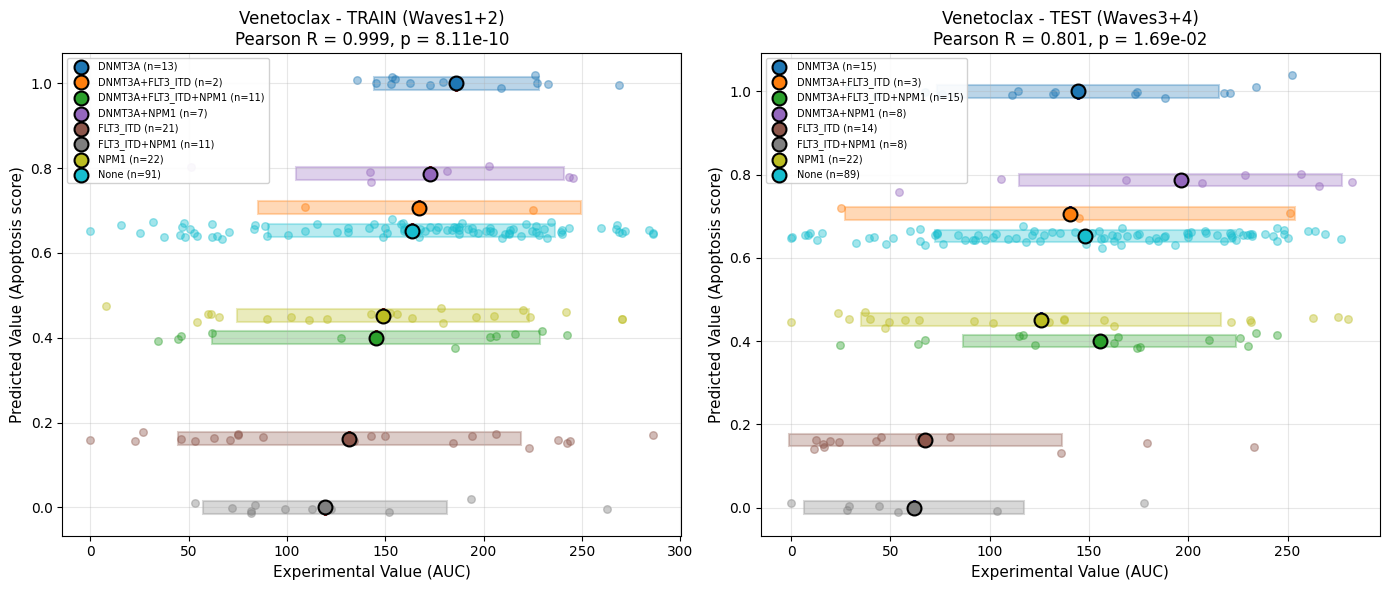

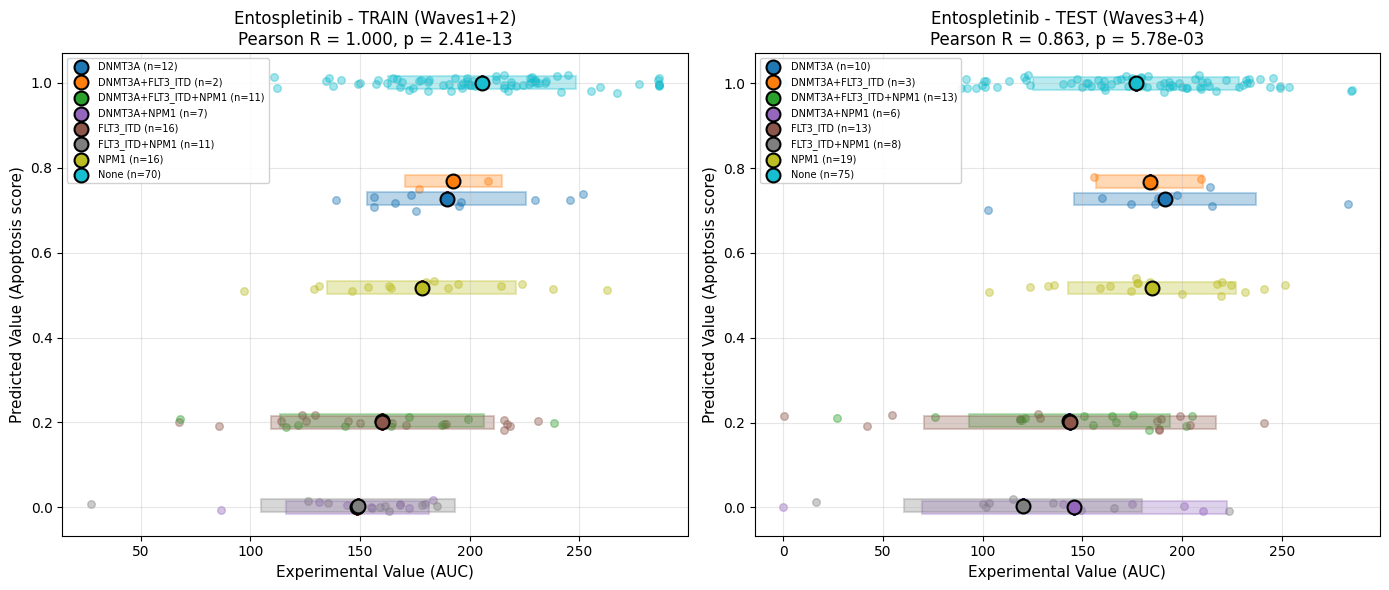

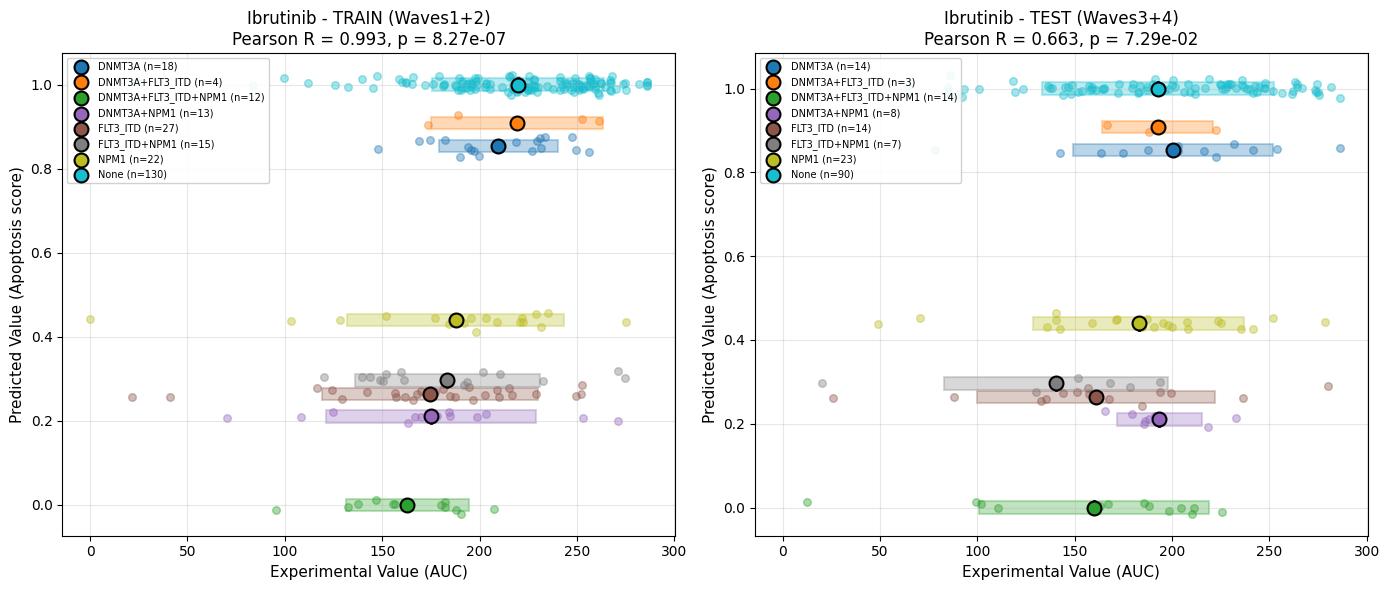

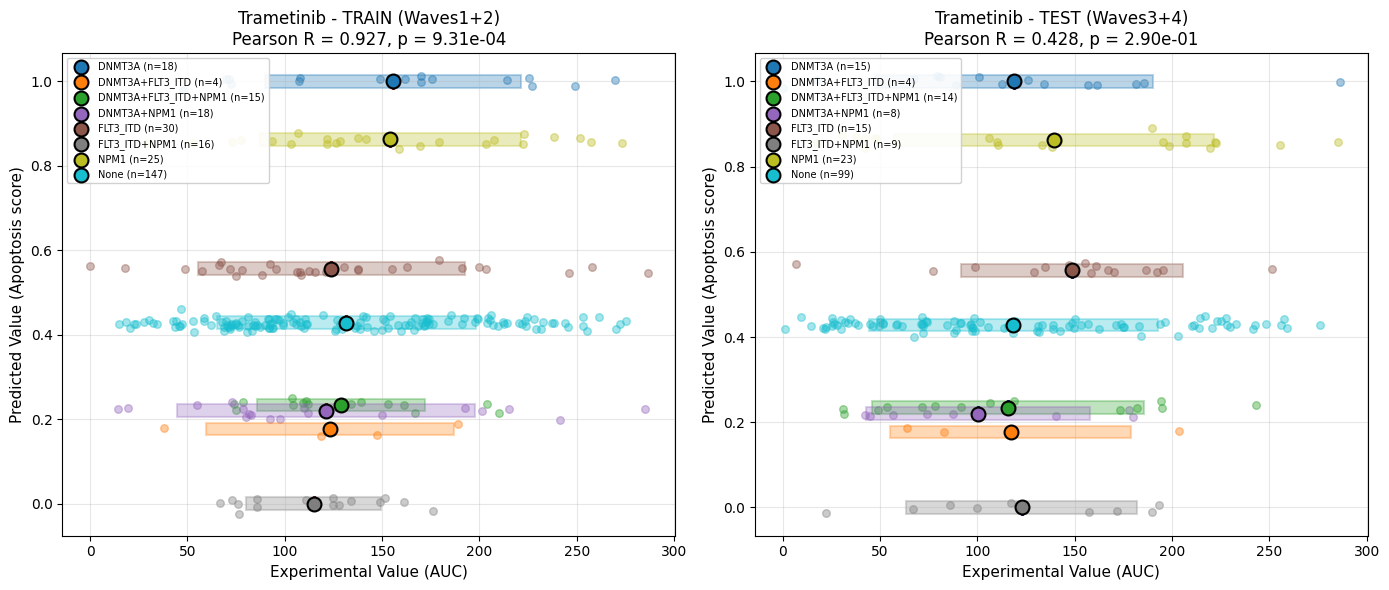

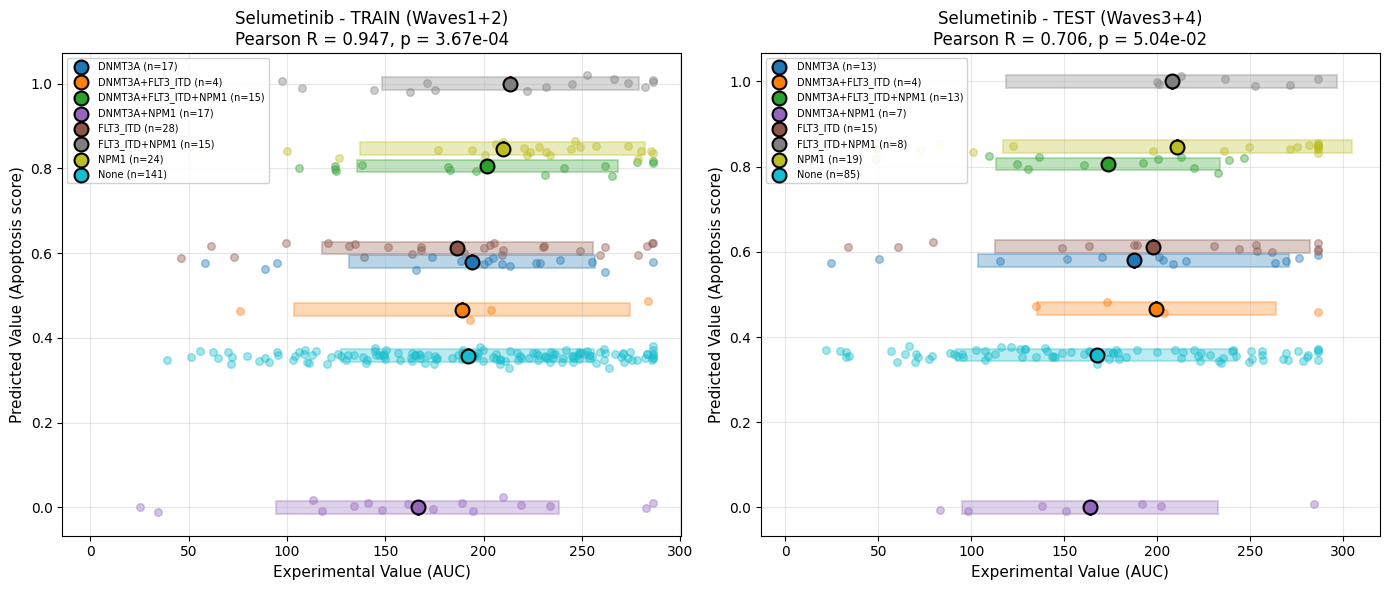

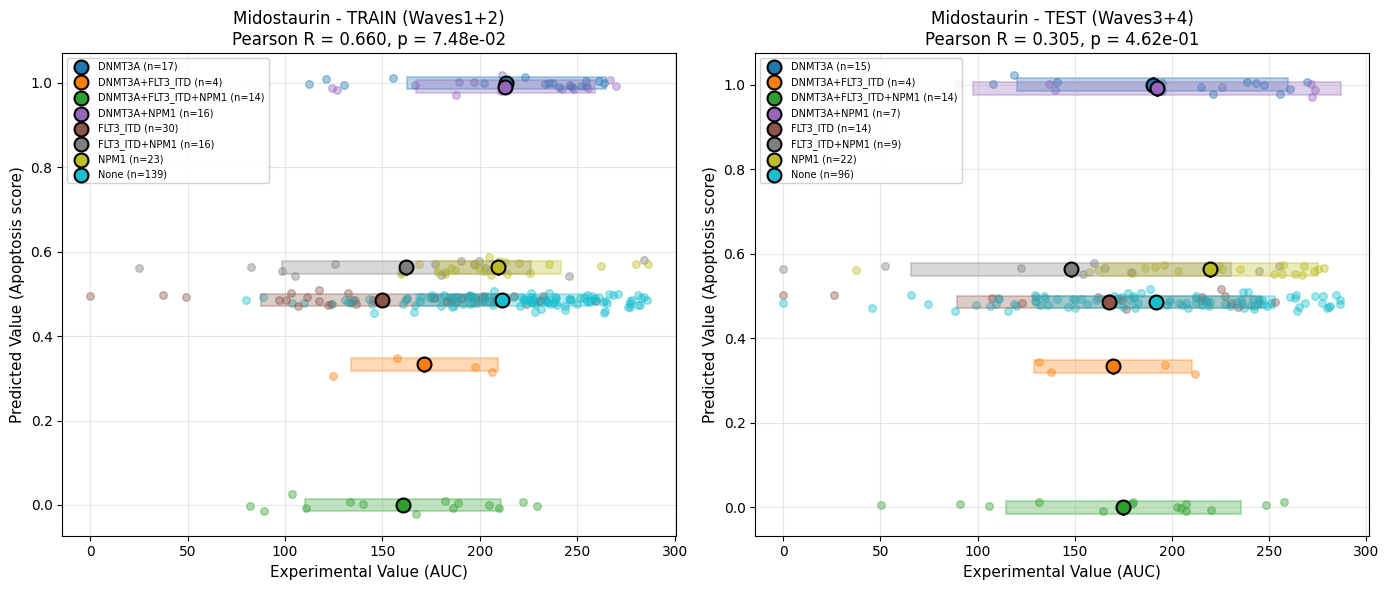

In [121]:
for drug in drugs:
    pred_vs_exp(drug,mutation_genes = ['FLT3_ITD', 'NPM1', 'DNMT3A'])

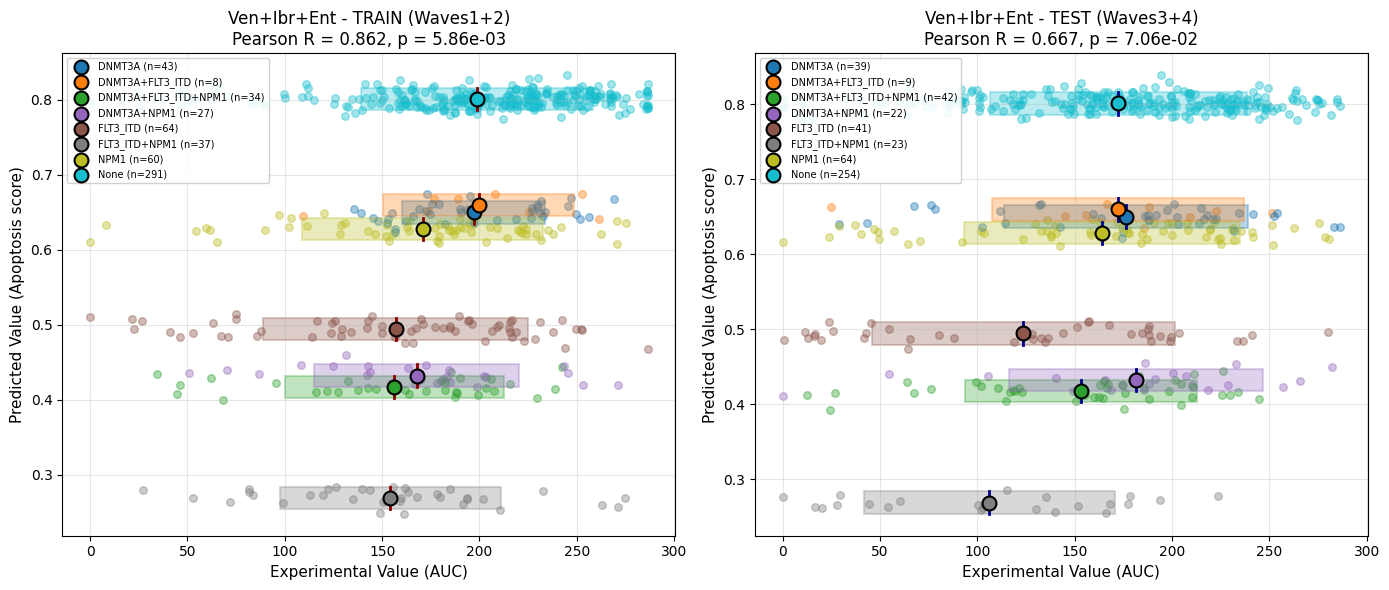

In [97]:
pred_vs_exp('Ven+Ibr+Ent',mutation_genes = ['FLT3_ITD', 'NPM1', 'DNMT3A'],drug2target = drug2target)

TRAIN: 564 samples, TEST: 494 samples
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/combined_train_test_correlation.png


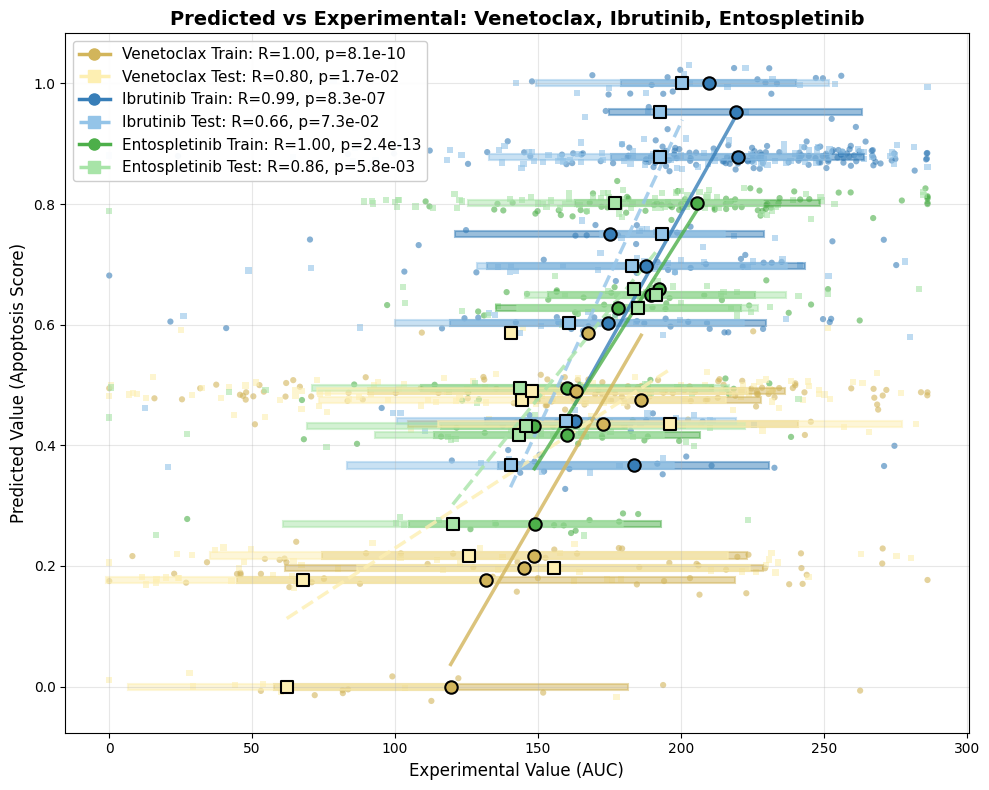

In [210]:
# Combined plot: 3 drugs, train+test on same plot with correlation lines for each

def combined_plot_train_test(drug, df, drug2target, save_path=None):
    """
    Combined plot for BeatAML data with 3 drugs, train and test on the same plot.
    Shows correlation lines for each drug-cohort combination with Pearson R and p annotated.
    """
    from scipy import stats
    from adjustText import adjust_text
    
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\{\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return "+".join(genes) if genes else "None"
    
    # Read simulation results from INDIVIDUAL drug folders (to match evaluation_report R values)
    # Load results for each drug separately
    individual_results = {}
    for drug_name in ['Venetoclax', 'Ibrutinib', 'Entospletinib']:
        train_path = f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug_name}_Waves1+2_AND+OR+IW/detailed_results.csv'
        test_path = f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug_name}_Waves1+2_AND+OR+IW/Waves3+4/detailed_results.csv'
        individual_results[drug_name] = {
            'train': pd.read_csv(train_path),
            'test': pd.read_csv(test_path)
        }
    
    # Also load combined results for plotting (normalized predicted values)
    train_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/detailed_results.csv')
    test_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/Waves3+4/detailed_results.csv')
    data_df = pd.read_csv(f'../data/BeatAML_AUC_{drug}_Waves1+2.csv')
    
    # Min-max normalize predicted values to 0-1 (combined normalization)
    def minmax_normalize(series):
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series * 0
        return (series - min_val) / (max_val - min_val)
    
    # Normalization
    all_pred = pd.concat([train_results_df['Predicted_Value'], test_results_df['Predicted_Value']])
    min_pred, max_pred = all_pred.min(), all_pred.max()
    train_results_df['Predicted_Normalized'] = (train_results_df['Predicted_Value'] - min_pred) / (max_pred - min_pred)
    test_results_df['Predicted_Normalized'] = (test_results_df['Predicted_Value'] - min_pred) / (max_pred - min_pred)

    # Extract mutation profile from data_df
    all_drug_targets = set()
    for targets in drug2target.values():
        all_drug_targets.update(targets)
    
    def get_profile_label_from_exp(row):
        mutated_genes = set()
        stimuli = str(row.get('Stimuli', ''))
        if stimuli and stimuli != 'nan':
            for gene in stimuli.split(','):
                gene = gene.strip()
                if gene:
                    if gene == 'FLT3':
                        mutated_genes.add('FLT3_ITD')
                    else:
                        mutated_genes.add(gene)
        inhibitors = str(row.get('Inhibitors', ''))
        if inhibitors and inhibitors != 'nan':
            for gene in inhibitors.split(','):
                gene = gene.strip()
                if gene and gene not in all_drug_targets:
                    mutated_genes.add(gene)
        if mutated_genes:
            return '+'.join(sorted(mutated_genes))
        return 'None'
    
    data_df['profile_label'] = data_df.apply(get_profile_label_from_exp, axis=1)
    
    # Get drug name
    def get_drug_name(row):
        inhibitors = str(row.get('Inhibitors', ''))
        for drug_name, targets in drug2target.items():
            for target in targets:
                if target in inhibitors:
                    return drug_name
        return 'Unknown'
    data_df['drug_name'] = data_df.apply(get_drug_name, axis=1)
    
    exp_to_profile = dict(zip(data_df['Experiments'], data_df['profile_label']))
    exp_to_drug = dict(zip(data_df['Experiments'], data_df['drug_name']))
    
    for df_res in [train_results_df, test_results_df]:
        df_res['profile_label'] = df_res['Experiment_ID'].map(exp_to_profile)
        df_res['drug_name'] = df_res['Experiment_ID'].map(exp_to_drug)
    
    # Get individual samples
    drug_samples = df[df['inhibitor'].str.contains('Venetoclax|Ibrutinib|Entospletinib', case=False, na=False)].copy()
    drug_samples['profile_label'] = drug_samples['mutation_profile'].apply(normalize_profile_text)
    
    def get_drug_from_inhibitor(inhibitor):
        inhibitor_lower = str(inhibitor).lower()
        if 'venetoclax' in inhibitor_lower:
            return 'Venetoclax'
        elif 'ibrutinib' in inhibitor_lower:
            return 'Ibrutinib'
        elif 'entospletinib' in inhibitor_lower:
            return 'Entospletinib'
        return 'Unknown'
    
    drug_samples['Drug_name'] = drug_samples['inhibitor'].apply(get_drug_from_inhibitor)
    
    # Separate by cohort
    train_samples = drug_samples[drug_samples['cohort'] == 'Waves1+2'].copy()
    test_samples = drug_samples[drug_samples['cohort'] == 'Waves3+4'].copy()
    
    # Define colors for each drug (solid for train, lighter for test)
    drug_colors_train = {
        'Venetoclax': '#D2B55B',   # Yellow
        'Ibrutinib': '#377EB8',    # Blue
        'Entospletinib': '#4DAF4A', # Green
    }
    drug_colors_test = {
        'Venetoclax': '#FDEFB2',   # Light yellow
        'Ibrutinib': '#94C4E8',    # Light blue
        'Entospletinib': '#A8E4A8', # Light green
    }
    
    # Create single figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    box_height = 0.01
    np.random.seed(42)
    
    # Prepare data for train and test
    # Train
    train_results_df['profile_drug'] = train_results_df['profile_label'] + '_' + train_results_df['drug_name']
    pred_map_df = train_results_df[['profile_drug', 'Predicted_Normalized']].drop_duplicates(subset='profile_drug', keep='first')
    train_pred_map = dict(zip(pred_map_df['profile_drug'], pred_map_df['Predicted_Normalized']))
    
    train_samples['profile_drug'] = train_samples['profile_label'] + '_' + train_samples['Drug_name']
    train_samples['predicted'] = train_samples['profile_drug'].map(train_pred_map)
    train_samples = train_samples.dropna(subset=['predicted', 'auc'])
    
    # Test
    test_results_df['profile_drug'] = test_results_df['profile_label'] + '_' + test_results_df['drug_name']
    pred_map_df_test = test_results_df[['profile_drug', 'Predicted_Normalized']].drop_duplicates(subset='profile_drug', keep='first')
    test_pred_map = dict(zip(pred_map_df_test['profile_drug'], pred_map_df_test['Predicted_Normalized']))
    
    test_samples['profile_drug'] = test_samples['profile_label'] + '_' + test_samples['Drug_name']
    test_samples['predicted'] = test_samples['profile_drug'].map(test_pred_map)
    test_samples = test_samples.dropna(subset=['predicted', 'auc'])
    
    print(f"TRAIN: {len(train_samples)} samples, TEST: {len(test_samples)} samples")
    
    # Plot individual samples - TRAIN (filled markers)
    for drug_name in ['Venetoclax', 'Ibrutinib', 'Entospletinib']:
        subset = train_samples[train_samples['Drug_name'] == drug_name]
        for _, row in subset.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.012)
            ax.scatter(row['auc'], y_jitter, alpha=0.6, s=20, color=drug_colors_train[drug_name], 
                      marker='o', edgecolor='none')
    
    # Plot individual samples - TEST (open markers)
    for drug_name in ['Venetoclax', 'Ibrutinib', 'Entospletinib']:
        subset = test_samples[test_samples['Drug_name'] == drug_name]
        for _, row in subset.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.012)
            ax.scatter(row['auc'], y_jitter, alpha=0.6, s=20, color=drug_colors_test[drug_name],
                      marker='s', edgecolor='none')
    
    # Calculate mean ± s.d. per profile-drug combination
    # TRAIN
    train_profile_means = train_samples.groupby(['profile_label', 'Drug_name']).agg({
        'auc': ['mean', 'std', 'count'],
        'predicted': 'first'
    }).reset_index()
    train_profile_means.columns = ['profile_label', 'Drug_name', 'auc_mean', 'auc_std', 'count', 'predicted']
    
    # TEST
    test_profile_means = test_samples.groupby(['profile_label', 'Drug_name']).agg({
        'auc': ['mean', 'std', 'count'],
        'predicted': 'first'
    }).reset_index()
    test_profile_means.columns = ['profile_label', 'Drug_name', 'auc_mean', 'auc_std', 'count', 'predicted']
    
    # Plot mean ± s.d. boxes - TRAIN (only if count > 3)
    for _, row in train_profile_means.iterrows():
        mean_val = row['auc_mean']
        std_val = row['auc_std'] if pd.notna(row['auc_std']) else 0
        pred = row['predicted']
        count = row['count']
        color = drug_colors_train[row['Drug_name']]
        
        # Only draw s.d. box if more than 3 points
        if count > 3 and std_val > 0:
            ax.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                        2*std_val, box_height, 
                                        facecolor=color, alpha=0.5, 
                                        linewidth=1.5, edgecolor=color))
        ax.scatter(mean_val, pred, s=80, color=color, edgecolor='black', linewidth=1.5, zorder=15, marker='o')
    
    # Plot mean ± s.d. boxes - TEST (only if count > 3)
    for _, row in test_profile_means.iterrows():
        mean_val = row['auc_mean']
        std_val = row['auc_std'] if pd.notna(row['auc_std']) else 0
        pred = row['predicted']
        count = row['count']
        color = drug_colors_test[row['Drug_name']]
        
        # Only draw s.d. box if more than 3 points
        if count > 3 and std_val > 0:
            ax.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                        2*std_val, box_height, 
                                        facecolor=color, alpha=0.5, 
                                        linewidth=1.5, edgecolor=color))
        ax.scatter(mean_val, pred, s=80, color=color, edgecolor='black', linewidth=1.5, zorder=15, marker='s')
    
    # Calculate and plot correlation lines for each drug-cohort combination
    # Use INDIVIDUAL drug results for R and p (same as evaluation_report.txt)
    corr_stats = {}
    
    for drug_name in ['Venetoclax', 'Ibrutinib', 'Entospletinib']:
        # Get individual drug results (from separate optimization runs)
        train_indiv = individual_results[drug_name]['train']
        test_indiv = individual_results[drug_name]['test']
        
        # TRAIN correlation - use individual drug results (matches evaluation_report.txt)
        train_drug_plot = train_profile_means[train_profile_means['Drug_name'] == drug_name]
        if len(train_indiv) >= 2:
            r_train, p_train = stats.pearsonr(train_indiv['Predicted_Value'], train_indiv['Measured_Value'])
            corr_stats[(drug_name, 'Train')] = (r_train, p_train)
        if len(train_drug_plot) >= 2:
            slope, intercept, _, _, _ = stats.linregress(train_drug_plot['auc_mean'], train_drug_plot['predicted'])
            x_line = np.linspace(train_drug_plot['auc_mean'].min(), train_drug_plot['auc_mean'].max(), 100)
            y_line = slope * x_line + intercept
            line_color = drug_colors_train[drug_name]
            ax.plot(x_line, y_line, color=line_color, linewidth=2.5, linestyle='-', alpha=0.8)
        
        # TEST correlation - use individual drug results (matches evaluation_report.txt)
        test_drug_plot = test_profile_means[test_profile_means['Drug_name'] == drug_name]
        if len(test_indiv) >= 2:
            r_test, p_test = stats.pearsonr(test_indiv['Predicted_Value'], test_indiv['Measured_Value'])
            corr_stats[(drug_name, 'Test')] = (r_test, p_test)
        if len(test_drug_plot) >= 2:
            slope, intercept, _, _, _ = stats.linregress(test_drug_plot['auc_mean'], test_drug_plot['predicted'])
            x_line = np.linspace(test_drug_plot['auc_mean'].min(), test_drug_plot['auc_mean'].max(), 100)
            y_line = slope * x_line + intercept
            line_color = drug_colors_test[drug_name]
            ax.plot(x_line, y_line, color=line_color, linewidth=2.5, linestyle='--', alpha=0.8)
    
    ax.set_xlabel('Experimental Value (AUC)', fontsize=12)
    ax.set_ylabel('Predicted Value (Apoptosis Score)', fontsize=12)
    ax.set_title(f'Predicted vs Experimental: Venetoclax, Ibrutinib, Entospletinib', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Legend with R and p values
    from matplotlib.lines import Line2D
    legend_elements = []
    
    for drug_name in ['Venetoclax', 'Ibrutinib', 'Entospletinib']:
        # Train
        if (drug_name, 'Train') in corr_stats:
            r, p = corr_stats[(drug_name, 'Train')]
            legend_elements.append(Line2D([0], [0], color=drug_colors_train[drug_name], linewidth=2.5, 
                                         linestyle='-', marker='o', markersize=8,
                                         label=f'{drug_name} Train: R={r:.2f}, p={p:.1e}'))
        # Test
        if (drug_name, 'Test') in corr_stats:
            r, p = corr_stats[(drug_name, 'Test')]
            legend_elements.append(Line2D([0], [0], color=drug_colors_test[drug_name], linewidth=2.5, 
                                         linestyle='--', marker='s', markersize=8,
                                         label=f'{drug_name} Test: R={r:.2f}, p={p:.1e}'))
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.95)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    
# Run the combined plot
combined_plot_train_test(
    drug='Ven+Ibr+Ent', 
    df=df, 
    drug2target=drug2target,
    save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/combined_train_test_correlation.png'
)

In [140]:
pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/pbn.txt')
formula = BNMPy.phenotype_scores(
    genes=pbn.nodeDict.keys(),
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=True
)
eval_result = BNMPy.evaluate_pbn(pbn, '../data/BeatAML_AUC_Ven+Ibr+Ent_Waves1+2.csv', 
    config=config, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    output_dir='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/Waves1+2')

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Path found for 1 phenotypes: ['APOPTOSIS']
Plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/Waves1+2_AND+OR+IW/prediction_vs_experimental.png
Residual plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/Waves1+2_AND+OR+IW/residual_analysis.png
Evaluation report saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/Waves1+2_AND+OR+IW/evaluation_report.txt
Results exported to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/Waves1+2_AND+OR+IW/detailed_results.csv
PBN saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/Waves1+2_AND+OR+IW/pbn.txt


In [229]:
def expanded_plot_beataml(drug, df, drug2target, use_spearman=False, save_path=None):
    """
    Expanded plot for BeatAML data with individual samples, colored by drug.
    Generates side-by-side plots for Waves1+2 (train) and Waves3+4 (test).
    
    Parameters:
    -----------
    drug : str
        Drug name or combined drugs (e.g., 'Venetoclax' or 'Ven+Ibr+Ent')
    df : DataFrame
        BeatAML data with columns: inhibitor, mutation_profile, auc, cohort
    drug2target : dict
        Mapping of drug names to their target genes
    use_spearman : bool
        If True, use Spearman correlation; otherwise use Pearson
    save_path : str
        Path to save the figure (optional)
    """
    from scipy import stats
    from scipy.stats import spearmanr
    from itertools import combinations
    from adjustText import adjust_text
    
    def normalize_profile_text(p):
        """Normalize mutation profile to consistent text format"""
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\{\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return "+".join(genes) if genes else "None"
    
    # Read simulation results
    train_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/detailed_results.csv')
    test_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/Waves3+4/detailed_results.csv')
    data_df = pd.read_csv(f'../data/BeatAML_AUC_{drug}_Waves1+2.csv')
    
    # Min-max normalize predicted values to 0-1
    def minmax_normalize(series):
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series * 0
        return (series - min_val) / (max_val - min_val)
    
    train_results_df['Predicted_Normalized'] = minmax_normalize(train_results_df['Predicted_Value'])
    test_results_df['Predicted_Normalized'] = minmax_normalize(test_results_df['Predicted_Value'])
    
    # Extract mutation profile from data_df
    all_drug_targets = set()
    for targets in drug2target.values():
        all_drug_targets.update(targets)
    
    def get_profile_label_from_exp(row):
        """Extract mutation profile from Stimuli and Inhibitors columns"""
        mutated_genes = set()
        stimuli = str(row.get('Stimuli', ''))
        if stimuli and stimuli != 'nan':
            for gene in stimuli.split(','):
                gene = gene.strip()
                if gene:
                    if gene == 'FLT3':
                        mutated_genes.add('FLT3_ITD')
                    else:
                        mutated_genes.add(gene)
        inhibitors = str(row.get('Inhibitors', ''))
        if inhibitors and inhibitors != 'nan':
            for gene in inhibitors.split(','):
                gene = gene.strip()
                if gene and gene not in all_drug_targets:
                    mutated_genes.add(gene)
        if mutated_genes:
            return '+'.join(sorted(mutated_genes))
        return 'None'
    
    # Add profile_label and drug name to data_df
    data_df['profile_label'] = data_df.apply(get_profile_label_from_exp, axis=1)
    
    # Get drug name from data_df if available, otherwise infer from inhibitor column
    if 'drug' in data_df.columns:
        exp_to_drug = dict(zip(data_df['Experiments'], data_df['drug']))
    else:
        # Infer drug from Inhibitors column
        def get_drug_name(row):
            inhibitors = str(row.get('Inhibitors', ''))
            for drug_name, targets in drug2target.items():
                for target in targets:
                    if target in inhibitors:
                        return drug_name
            return 'Unknown'
        data_df['drug_name'] = data_df.apply(get_drug_name, axis=1)
        exp_to_drug = dict(zip(data_df['Experiments'], data_df['drug_name']))
    
    exp_to_profile = dict(zip(data_df['Experiments'], data_df['profile_label']))
    
    train_results_df['profile_label'] = train_results_df['Experiment_ID'].map(exp_to_profile)
    train_results_df['drug_name'] = train_results_df['Experiment_ID'].map(exp_to_drug)
    test_results_df['profile_label'] = test_results_df['Experiment_ID'].map(exp_to_profile)
    test_results_df['drug_name'] = test_results_df['Experiment_ID'].map(exp_to_drug)
    
    # Get individual samples from df
    if drug == 'Ven+Ibr+Ent':
        drug_samples = df[df['inhibitor'].str.contains('Venetoclax|Ibrutinib|Entospletinib', case=False, na=False)].copy()
    else:
        drug_samples = df[df['inhibitor'].str.contains(drug, case=False, na=False)].copy()
    
    drug_samples['profile_label'] = drug_samples['mutation_profile'].apply(normalize_profile_text)
    
    # Map inhibitor to drug name for coloring
    def get_drug_from_inhibitor(inhibitor):
        inhibitor_lower = str(inhibitor).lower()
        if 'venetoclax' in inhibitor_lower:
            return 'Venetoclax'
        elif 'ibrutinib' in inhibitor_lower:
            return 'Ibrutinib'
        elif 'entospletinib' in inhibitor_lower:
            return 'Entospletinib'
        elif 'trametinib' in inhibitor_lower:
            return 'Trametinib'
        elif 'selumetinib' in inhibitor_lower:
            return 'Selumetinib'
        elif 'midostaurin' in inhibitor_lower:
            return 'Midostaurin'
        return 'Unknown'
    
    drug_samples['Drug_name'] = drug_samples['inhibitor'].apply(get_drug_from_inhibitor)
    
    # Separate by cohort
    train_samples = drug_samples[drug_samples['cohort'] == 'Waves1+2'].copy()
    test_samples = drug_samples[drug_samples['cohort'] == 'Waves3+4'].copy()
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Define colors for each drug
    drug_colors = {
        'Venetoclax': '#D2B55B',   # Yellow
        'Ibrutinib': '#377EB8',    # Blue
        'Entospletinib': '#4DAF4A', # Green
        'Trametinib': '#984EA3',   # Purple
        'Selumetinib': '#FF7F00',  # Orange
        'Midostaurin': '#FFFF33',  # Yellow
    }
    
    box_height = 0.01
    np.random.seed(42)
    
    # --- TRAIN PLOT (Waves1+2) ---
    # Create profile_drug mapping for train
    train_results_df['profile_drug'] = train_results_df['profile_label'] + '_' + train_results_df['drug_name']
    pred_map_df = train_results_df[['profile_drug', 'Predicted_Normalized']].drop_duplicates(subset='profile_drug', keep='first')
    train_pred_map = dict(zip(pred_map_df['profile_drug'], pred_map_df['Predicted_Normalized']))
    
    train_samples['profile_drug'] = train_samples['profile_label'] + '_' + train_samples['Drug_name']
    train_samples['predicted'] = train_samples['profile_drug'].map(train_pred_map)
    train_samples = train_samples.dropna(subset=['predicted', 'auc'])
    
    print(f"TRAIN: Matched {len(train_samples)} individual samples to predictions")
    
    if len(train_samples) > 0:
        # Plot individual samples with jitter
        for _, row in train_samples.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.012)
            color = drug_colors.get(row['Drug_name'], 'gray')
            ax1.scatter(row['auc'], y_jitter, alpha=0.4, s=30, color=color)
        
        # Calculate mean ± s.d. per profile-drug combination
        profile_drug_means = train_samples.groupby(['profile_label', 'Drug_name']).agg({
            'auc': ['mean', 'std', 'count'],
            'predicted': 'first'
        }).reset_index()
        profile_drug_means.columns = ['profile_label', 'Drug_name', 'auc_mean', 'auc_std', 'count', 'predicted']
        
        # Correlation
        if use_spearman:
            r, p_value = spearmanr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Spearman'
        else:
            r, p_value = stats.pearsonr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Pearson'
        
        # Correlation line
        if len(profile_drug_means) >= 2:
            slope, intercept, _, _, _ = stats.linregress(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            x_line = np.linspace(profile_drug_means['auc_mean'].min(), profile_drug_means['auc_mean'].max(), 100)
            y_line = slope * x_line + intercept
            ax1.plot(x_line, y_line, color='gray', linewidth=2, linestyle='--', alpha=0.8)

        # Plot mean ± s.d. patches and collect text annotations
        train_texts = []
        for _, row in profile_drug_means.iterrows():
            mean_val = row['auc_mean']
            std_val = row['auc_std'] if pd.notna(row['auc_std']) else 0
            pred = row['predicted']
            color = drug_colors.get(row['Drug_name'], 'gray')
            
            # Horizontal patch for mean ± s.d.
            ax1.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                        2*std_val, box_height, 
                                        facecolor=color, alpha=0.3, 
                                        linewidth=1.5, edgecolor=color))
            ax1.plot([mean_val, mean_val], [pred - box_height/2, pred + box_height/2], 
                    color='darkred', linewidth=2, zorder=10)
            ax1.scatter(mean_val, pred, s=100, color=color, edgecolor='black', linewidth=1.5, zorder=15)
            
            # Collect text annotations for adjustText
            txt = ax1.text(mean_val, pred, f'{row["profile_label"]}', 
                          fontsize=7, alpha=0.8, ha='center', va='top')
            train_texts.append(txt)
        
        # Adjust text positions to avoid overlap
        adjust_text(train_texts, ax=ax1, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
        
        ax1.set_xlabel('Experimental Value (AUC)', fontsize=11)
        ax1.set_ylabel('Predicted Value (Apoptosis Score)', fontsize=11)
        ax1.set_title(f'{drug} - TRAIN (Waves1+2)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
    
    # --- TEST PLOT (Waves3+4) ---
    test_results_df['profile_drug'] = test_results_df['profile_label'] + '_' + test_results_df['drug_name']
    pred_map_df = test_results_df[['profile_drug', 'Predicted_Normalized']].drop_duplicates(subset='profile_drug', keep='first')
    test_pred_map = dict(zip(pred_map_df['profile_drug'], pred_map_df['Predicted_Normalized']))
    
    test_samples['profile_drug'] = test_samples['profile_label'] + '_' + test_samples['Drug_name']
    test_samples['predicted'] = test_samples['profile_drug'].map(test_pred_map)
    test_samples = test_samples.dropna(subset=['predicted', 'auc'])
    
    print(f"TEST: Matched {len(test_samples)} individual samples to predictions")
    
    if len(test_samples) > 0:
        # Plot individual samples with jitter
        for _, row in test_samples.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.012)
            color = drug_colors.get(row['Drug_name'], 'gray')
            ax2.scatter(row['auc'], y_jitter, alpha=0.4, s=30, color=color)
        
        # Calculate mean ± s.d. per profile-drug combination
        profile_drug_means = test_samples.groupby(['profile_label', 'Drug_name']).agg({
            'auc': ['mean', 'std', 'count'],
            'predicted': 'first'
        }).reset_index()
        profile_drug_means.columns = ['profile_label', 'Drug_name', 'auc_mean', 'auc_std', 'count', 'predicted']
        
        # Correlation
        if use_spearman:
            r, p_value = spearmanr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Spearman'
        else:
            r, p_value = stats.pearsonr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Pearson'

        # Correlation line
        if len(profile_drug_means) >= 2:
            slope, intercept, _, _, _ = stats.linregress(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            x_line = np.linspace(profile_drug_means['auc_mean'].min(), profile_drug_means['auc_mean'].max(), 100)
            y_line = slope * x_line + intercept
            line_color = drug_colors[drug_name]
            ax2.plot(x_line, y_line, color='gray', linewidth=2, linestyle='--', alpha=0.8)    
                
        # Plot mean ± s.d. patches and collect text annotations
        test_texts = []
        for _, row in profile_drug_means.iterrows():
            mean_val = row['auc_mean']
            std_val = row['auc_std'] if pd.notna(row['auc_std']) else 0
            pred = row['predicted']
            color = drug_colors.get(row['Drug_name'], 'gray')
            
            ax2.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                        2*std_val, box_height, 
                                        facecolor=color, alpha=0.3, 
                                        linewidth=1.5, edgecolor=color))
            ax2.plot([mean_val, mean_val], [pred - box_height/2, pred + box_height/2], 
                    color='darkblue', linewidth=2, zorder=10)
            ax2.scatter(mean_val, pred, s=100, color=color, edgecolor='black', linewidth=1.5, zorder=15)
            
            # Collect text annotations for adjustText
            txt = ax2.text(mean_val, pred, f'{row["profile_label"]}', 
                          fontsize=7, alpha=0.8, ha='center', va='top')
            test_texts.append(txt)
        
        # Adjust text positions to avoid overlap
        adjust_text(test_texts, ax=ax2, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
        
        ax2.set_xlabel('Experimental Value (AUC)', fontsize=11)
        ax2.set_ylabel('Predicted Value (Apoptosis Score)', fontsize=11)
        ax2.set_title(f'{drug} - TEST (Waves3+4)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    # Legend for drugs (outside plot)
    used_drugs = set(drug_samples['Drug_name'].unique())
    legend_handles = [plt.scatter([], [], c=drug_colors.get(d, 'gray'), s=60, label=d) 
                      for d in drug_colors.keys() if d in used_drugs]
    ax2.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

TRAIN: Matched 564 individual samples to predictions
TEST: Matched 494 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


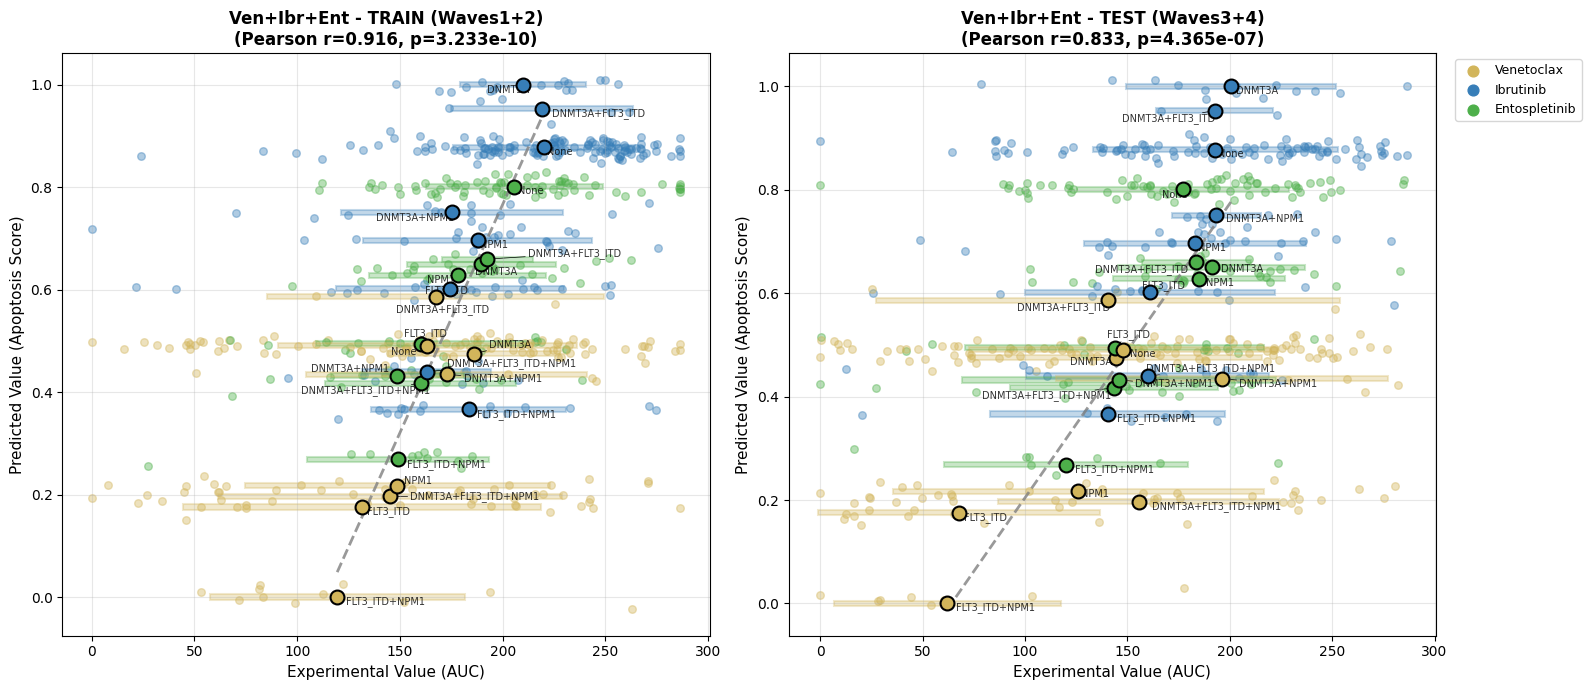

In [230]:
# Plot for combined drugs (Venetoclax + Ibrutinib + Entospletinib)
expanded_plot_beataml(
    drug='Ven+Ibr+Ent', 
    df=df, 
    drug2target=drug2target, 
    use_spearman=False,
    save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png'
)

# FPMTB data

Data was downloaded from https://zenodo.org/records/7370747

In [233]:
df_mutation = pd.read_excel('/Users/luna/Desktop/Pancreatic cancer/Data/AML_FPMTB/Functional_Precision_Medicine_Tumor_Board_AML/File_6_Binary_mutation_225S_57G.xlsx',index_col=0)
df_dss = pd.read_excel('/Users/luna/Desktop/Pancreatic cancer/Data/AML_FPMTB/Functional_Precision_Medicine_Tumor_Board_AML/File_3.1_Drug_response_sDSS_164S_17Healthy.xlsx',index_col=0)
df_dss.set_index('Drug_name',inplace=True)

In [234]:
gene_of_interest = ['FLT3','NPM1','DNMT3A']

# Filter mutations to genes of interest
genes_to_use = df_mutation.index.intersection(gene_of_interest)
df_mut_filt = df_mutation.loc[genes_to_use]

# Build mutation_profile per sample (set of mutated genes)
mutation_profile = df_mut_filt.apply(
    lambda col: {gene for gene, val in col.items() if val == 1},
    axis=0
)

# Filter DSS to selected drugs
drugs_to_use = df_dss.index.intersection(drugs)
df_dss_filt = df_dss.loc[drugs_to_use]

# Long-format DSS: one row per (sample, drug)
df_long = (
    df_dss_filt
    .reset_index()    
    .rename(columns={'index': 'drug'})
    .melt(id_vars='Drug_name',
          var_name='sample_id',
          value_name='DSS')
)

# drop missing DSS values
df_long = df_long.dropna(subset=['DSS'])

# Add mutation_profile column
df_long['mutation_profile'] = df_long['sample_id'].map(mutation_profile)
df_long = df_long.dropna(subset=['mutation_profile'])
df_long

,Drug_name,sample_id,DSS,mutation_profile
0,Selumetinib,AML_084_04,15.46,{}
1,Trametinib,AML_084_04,16.54,{}
2,Midostaurin,AML_084_04,-0.96,{}
3,Ibrutinib,AML_084_04,0.00,{}
4,Venetoclax,AML_084_04,-2.14,{}
...,...,...,...,...
979,Trametinib,AML_183_02,10.03,{}
980,Midostaurin,AML_183_02,9.23,{}
981,Ibrutinib,AML_183_02,0.00,{}
982,Venetoclax,AML_183_02,1.10,{}


In [89]:
df_long['mutation_profile'].value_counts()

mutation_profile
{}                      513
{DNMT3A}                 64
{NPM1}                   49
{DNMT3A, NPM1}           33
{FLT3}                   30
{FLT3, DNMT3A}           21
{FLT3, NPM1}             18
{FLT3, DNMT3A, NPM1}     15
Name: count, dtype: int64

In [235]:
def create_FPMTB(df, gene_of_interest,
                    inhibitors=['Venetoclax'],
                    drug2target=None,
                    min_patients=3,
                    output_file='beataml_experiments.csv'):
    """
    Create experimental data CSV from FPMTB drug response data.
    
    Parameters:
    - df: DataFrame with mutation_profile, Drug_name, and DSS columns
    - gene_of_interest: List of genes
    - inhibitors: List of drug names
    - min_patients: Minimum number of patients per profile
    - output_file: Output CSV filename
    
    Note: Oncogenes become Stimuli, TSGs become Inhibitors based on gene_to_class
    """
    
    # Drug to target mapping
    if drug2target is None:
        drug2target = {
            'Venetoclax': ['BCL2'],
            'Ibrutinib': ['BTK'], 
            'Entospletinib': ['SYK'],
            }
    
    # Normalize profile text for comparison
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else: 
            s = re.sub(r'[\\{\\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return set(genes) if genes else set()
    
    df_work = df.copy()
    df_work['profile_set'] = df_work['mutation_profile'].apply(normalize_profile_text)
   
    # Generate all mutation profile combinations
    from itertools import combinations
    all_profiles = []
    for r in range(len(gene_of_interest) + 1):
        for combo in combinations(gene_of_interest, r):
            all_profiles.append(set(combo))
    
    print(f"\nGenerating data for {len(all_profiles)} profiles × {len(inhibitors)} drugs = {len(all_profiles) * len(inhibitors)} experiments")
    
    # Create experiment rows
    experiments = []
    exp_id = 1
    
    for profile in all_profiles:
        for drug in inhibitors:
            # Filter data for this profile and drug
            matching_data = df_work[
                (df_work['profile_set'] == profile) & 
                (df_work['Drug_name'] == drug)
            ]
            
            if len(matching_data) == 0:
                continue
            
            # Calculate average AUC
            avg_dss = matching_data['DSS'].mean()
            std_dss = matching_data['DSS'].std()
            n_patients = len(matching_data)
            if n_patients < min_patients:
                print(f"Not enough patients for {drug} {profile}, skipping...")
                continue
            
            # Classify genes as oncogenes or TSGs
            oncogenes = []
            tsgs = []
            
            for gene in profile:
                gene_class = gene_to_class.get(gene, 'unknown')
                if gene_class == 'oncogene':
                    oncogenes.append(gene)
                elif gene_class == 'TSG':
                    tsgs.append(gene)
                else:
                    print(f"Warning: Unknown classification for {gene}, treating as oncogene")
                    oncogenes.append(gene)
            
            # Oncogenes → Stimuli (activate)
            stimuli = ','.join(sorted(oncogenes)) if oncogenes else ''
            stimuli_efficacy = ','.join(['1'] * len(oncogenes)) if oncogenes else ''
            
            # TSGs + Drug target → Inhibitors (knockdown)
            target = drug2target.get(drug, '')
            if not target:
                print(f"Warning: No target mapping for {drug}, skipping...")
                continue
            
            all_inhibitors = sorted(tsgs + target)
            inhibitors_str = ','.join(all_inhibitors)
            inhibitors_efficacy = ','.join(['1'] * len(all_inhibitors))
            
            measured_nodes = 'DSS'
            measured_values = f'{avg_dss:.2f}'
            
            experiments.append({
                'Experiments': exp_id,
                'Stimuli': stimuli,
                'Stimuli_efficacy': stimuli_efficacy,
                'Inhibitors': inhibitors_str,
                'Inhibitors_efficacy': inhibitors_efficacy,
                'Measured_nodes': measured_nodes,
                'Measured_values': measured_values,
                'n_patients': n_patients,
                'std': f'{std_dss:.2f}',
                'drug': drug
            })
            
            exp_id += 1
    
    # Create DataFrame
    exp_df = pd.DataFrame(experiments)
    
    # Save to CSV
    exp_df.to_csv(output_file, index=False)
    
    print(f"\nSaved {len(exp_df)} experiments to {output_file}")
    print(f"\nSummary by drug:")
    print(exp_df.groupby('drug').agg({
        'n_patients': 'sum',
        'Measured_values': lambda x: f"{pd.to_numeric(x).mean():.2f}±{pd.to_numeric(x).std():.2f}"
    }).rename(columns={'Measured_values': 'Mean DSS±SD', 'n_patients': 'Total patients'}))
    
    return exp_df 

In [112]:
create_FPMTB(df_long, gene_of_interest = gene_of_interest,
                            inhibitors=['Ibrutinib','Entospletinib','Venetoclax'],
                            drug2target=drug2target,
                            output_file='../data/FPMTB_sDSS_Ven+Ibr+Ent.csv')


Generating data for 8 profiles × 3 drugs = 24 experiments
Not enough patients for Venetoclax {'FLT3'}, skipping...
Not enough patients for Entospletinib {'DNMT3A', 'FLT3'}, skipping...

Saved 21 experiments to ../data/FPMTB_sDSS_Ven+Ibr+Ent.csv

Summary by drug:
               Total patients Mean DSS±SD
drug                                     
Entospletinib              75   0.55±0.62
Ibrutinib                 132   0.62±0.12
Venetoclax                107  10.50±3.91


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BTK,1,DSS,0.71,90,1.61,Ibrutinib
1,2,,,SYK,1,DSS,0.43,52,1.19,Entospletinib
2,3,,,BCL2,1,DSS,8.04,78,9.61,Venetoclax
3,4,FLT3,1,BTK,1,DSS,0.72,5,1.61,Ibrutinib
4,5,FLT3,1,SYK,1,DSS,0.00,3,0.00,Entospletinib
5,6,,,"BTK,NPM1","1,1",DSS,0.43,9,0.72,Ibrutinib
6,7,,,"NPM1,SYK","1,1",DSS,1.07,6,2.24,Entospletinib
7,8,,,"BCL2,NPM1","1,1",DSS,8.73,7,9.11,Venetoclax
8,9,,,"BTK,DNMT3A","1,1",DSS,0.55,12,1.30,Ibrutinib
9,10,,,"DNMT3A,SYK","1,1",DSS,0.27,7,0.68,Entospletinib


In [270]:
pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/pbn.txt')
formula = BNMPy.phenotype_scores(
    genes=pbn.nodeDict.keys(),
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=True
)
eval_result = BNMPy.evaluate_pbn(pbn, '../data/FPMTB_sDSS_Ven+Ibr+Ent.csv', 
    config=config, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    output_dir='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent')

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Path found for 1 phenotypes: ['APOPTOSIS']
Plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/prediction_vs_experimental.png
Residual plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/residual_analysis.png
Evaluation report saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/evaluation_report.txt
Results exported to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/detailed_results.csv
PBN saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/pbn.txt


In [276]:
def expanded_plot(data_df, df_long, eval_result, drug2target, use_spearman=False, save_path=None):
    # Expanded plot: show individual samples instead of aggregated experiments
    import numpy as np
    from scipy import stats
    from scipy.stats import spearmanr
    from adjustText import adjust_text

    def normalize_profile_text(p):
        """Normalize mutation profile to consistent text format"""
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\{\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return "+".join(genes) if genes else "None"

    # Get predicted values from eval_result
    sim_results = eval_result['simulation_results']
    exp_ids = sim_results['experiment_ids']

    # Min-max normalize predicted values to 0-1
    def minmax_normalize(values):
        arr = np.array(values)
        min_val = np.min(arr)
        max_val = np.max(arr)
        if max_val - min_val == 0:
            return np.zeros_like(arr, dtype=float)
        return (arr - min_val) / (max_val - min_val)
    predicted_values = minmax_normalize(sim_results['predicted_values'])

    # Create mapping: experiment_id -> predicted_value
    exp_to_pred = dict(zip(exp_ids, predicted_values))

    # Also get the profile_label and drug for each experiment from data_df
    all_drug_targets = set()
    for targets in drug2target.values():
        all_drug_targets.update(targets)

    def get_profile_label_from_row(row):
        """Extract mutation profile from Stimuli and Inhibitors columns"""
        mutated_genes = set()
        stimuli = str(row.get('Stimuli', ''))
        if stimuli and stimuli != 'nan':
            for gene in stimuli.split(','):
                gene = gene.strip()
                if gene:
                    mutated_genes.add(gene)
        inhibitors = str(row.get('Inhibitors', ''))
        if inhibitors and inhibitors != 'nan':
            for gene in inhibitors.split(','):
                gene = gene.strip()
                if gene and gene not in all_drug_targets:
                    mutated_genes.add(gene)
        if mutated_genes:
            return '+'.join(sorted(mutated_genes))
        return 'None'

    data_df['profile_label'] = data_df.apply(get_profile_label_from_row, axis=1)
    data_df['predicted'] = data_df['Experiments'].map(exp_to_pred)

    # Create mapping: (profile_label, drug) -> predicted_value
    profile_drug_to_pred = {}
    for _, row in data_df.iterrows():
        key = (row['profile_label'], row['drug'])
        profile_drug_to_pred[key] = row['predicted']

    # Map individual samples in df_long to predicted values
    df_samples = df_long.copy()
    df_samples['profile_label'] = df_samples['mutation_profile'].apply(normalize_profile_text)
    df_samples['profile_drug'] = list(zip(df_samples['profile_label'], df_samples['Drug_name']))
    df_samples['predicted'] = df_samples['profile_drug'].map(profile_drug_to_pred)
    df_samples = df_samples.dropna(subset=['predicted', 'DSS'])

    print(f"Matched {len(df_samples)} individual samples to predictions")

    # Create the expanded plot
    fig, ax = plt.subplots(figsize=(8, 7))

    # Define colors for each drug
    drug_colors = {
        'Venetoclax': '#D2B55B',   # Yellow
        'Ibrutinib': '#377EB8',    # Blue
        'Entospletinib': '#4DAF4A', # Green
        # 'Trametinib': '#984EA3',   # Purple
        # 'Selumetinib': '#FF7F00',  # Orange
        # 'Midostaurin': '#FFFF33',  # Yellow
    }

    # Plot individual samples with jitter on y-axis
    np.random.seed(42) 
    for _, row in df_samples.iterrows():
        y_jitter = row['predicted'] + np.random.normal(0, 0.015)
        color = drug_colors.get(row['Drug_name'], 'gray')
        ax.scatter(row['DSS'], y_jitter, alpha=0.4, s=30, color=color)

    # Calculate and plot mean ± s.d. for each profile-drug combination
    profile_drug_means = df_samples.groupby(['profile_label', 'Drug_name']).agg({
        'DSS': ['mean', 'std', 'count'],
        'predicted': 'first'
    }).reset_index()
    profile_drug_means.columns = ['profile_label', 'Drug_name', 'DSS_mean', 'DSS_std', 'count', 'predicted']

    # Correlation on means (Spearman or Pearson based on option)
    if use_spearman:
        r, p_value = spearmanr(profile_drug_means['DSS_mean'], profile_drug_means['predicted'])
        corr_label = 'Spearman'
    else:
        r, p_value = stats.pearsonr(profile_drug_means['DSS_mean'], profile_drug_means['predicted'])
        corr_label = 'Pearson'

    box_height = 0.01
    texts = []
    for _, row in profile_drug_means.iterrows():
        # print(f"drug: {row['Drug_name']}, profile: {row['profile_label']}, n: {row['count']}")
        mean_val = row['DSS_mean']
        std_val = row['DSS_std'] if pd.notna(row['DSS_std']) else 0
        pred = row['predicted']
        color = drug_colors.get(row['Drug_name'], 'gray')
        
        # Horizontal patch for mean ± s.d. in DSS (like in pred_vs_exp)
        ax.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                    2*std_val, box_height, 
                                    facecolor=color, alpha=0.3, 
                                    linewidth=1.5, edgecolor=color))
        # Vertical line at mean
        ax.plot([mean_val, mean_val], [pred - box_height/2, pred + box_height/2], 
                color='darkred', linewidth=2, zorder=10)
        
        # Mean marker
        ax.scatter(mean_val, pred, s=100, color=color, edgecolor='black', linewidth=1.5, zorder=15)
        
        # Collect text annotations for adjustText
        txt = ax.text(mean_val, pred, f'{row["profile_label"]} (n={int(row["count"])})      ', 
                     fontsize=7, alpha=0.8, ha='right', va='top')
        texts.append(txt)
    
    # Adjust text positions to avoid overlap
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Regression line
    slope, intercept, _, _, _ = stats.linregress(df_samples['DSS'], df_samples['predicted'])
    x_reg = np.linspace(df_samples['DSS'].min(), df_samples['DSS'].max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'k--', linewidth=1.5, alpha=0.6, label='Regression line')

    # Legend for drugs
    legend_handles = [plt.scatter([], [], c=color, s=60, label=drug) 
                    for drug, color in drug_colors.items()]
    ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(0.98, 1), fontsize=9)

    ax.set_xlabel('Experimental Value (DSS)', fontsize=11)
    ax.set_ylabel('Predicted Value (Apoptosis Score)', fontsize=11)
    ax.set_title(f'{drug} - TEST (FPMTB)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")

Matched 314 individual samples to predictions


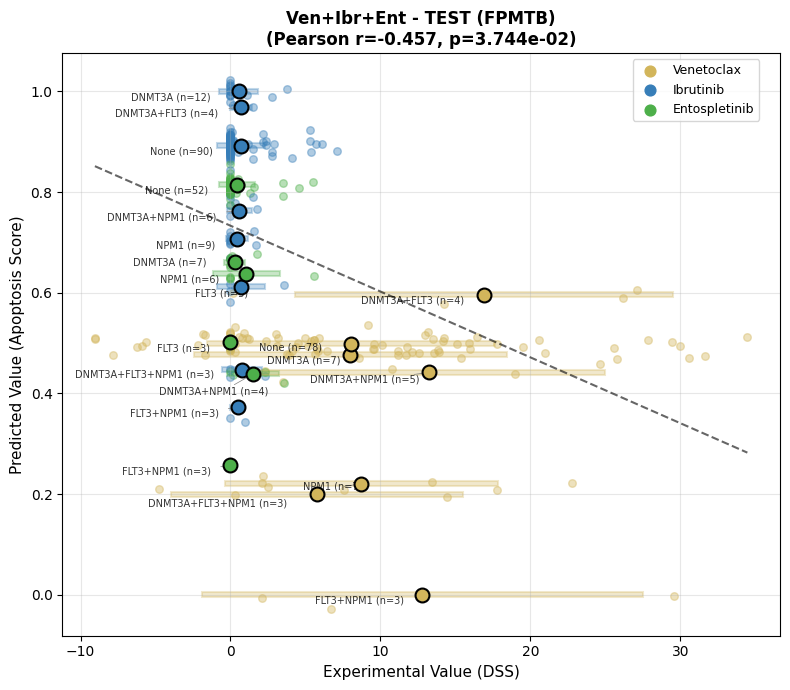

Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/prediction_vs_experimental_individual.png


In [277]:
data_df = pd.read_csv('../data/FPMTB_sDSS_Ven+Ibr+Ent.csv')
drug = 'Ven+Ibr+Ent'
expanded_plot(data_df, df_long, eval_result, drug2target, use_spearman=False, save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent/prediction_vs_experimental_individual.png')

In [128]:
create_FPMTB(df_long, gene_of_interest = gene_of_interest,
                            inhibitors=['Ibrutinib','Entospletinib','Venetoclax'],
                            drug2target=drug2target,
                            min_patients=5,
                            output_file='../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv')


Generating data for 8 profiles × 3 drugs = 24 experiments
Not enough patients for Entospletinib {'FLT3'}, skipping...
Not enough patients for Venetoclax {'FLT3'}, skipping...
Not enough patients for Ibrutinib {'NPM1', 'FLT3'}, skipping...
Not enough patients for Entospletinib {'NPM1', 'FLT3'}, skipping...
Not enough patients for Venetoclax {'NPM1', 'FLT3'}, skipping...
Not enough patients for Ibrutinib {'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Entospletinib {'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Venetoclax {'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Entospletinib {'NPM1', 'DNMT3A'}, skipping...
Not enough patients for Ibrutinib {'NPM1', 'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Venetoclax {'NPM1', 'DNMT3A', 'FLT3'}, skipping...

Saved 12 experiments to ../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv

Summary by drug:
               Total patients Mean DSS±SD
drug                                     
Entospletinib              65   0.59±0

,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BTK,1,DSS,0.71,90,1.61,Ibrutinib
1,2,,,SYK,1,DSS,0.43,52,1.19,Entospletinib
2,3,,,BCL2,1,DSS,8.04,78,9.61,Venetoclax
3,4,FLT3,1,BTK,1,DSS,0.72,5,1.61,Ibrutinib
4,5,,,"BTK,NPM1","1,1",DSS,0.43,9,0.72,Ibrutinib
5,6,,,"NPM1,SYK","1,1",DSS,1.07,6,2.24,Entospletinib
6,7,,,"BCL2,NPM1","1,1",DSS,8.73,7,9.11,Venetoclax
7,8,,,"BTK,DNMT3A","1,1",DSS,0.55,12,1.30,Ibrutinib
8,9,,,"DNMT3A,SYK","1,1",DSS,0.27,7,0.68,Entospletinib
9,10,,,"BCL2,DNMT3A","1,1",DSS,8.00,7,10.44,Venetoclax


In [278]:
pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/pbn.txt')
formula = BNMPy.phenotype_scores(
    genes=pbn.nodeDict.keys(),
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=True
)
eval_result = BNMPy.evaluate_pbn(pbn, '../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv', 
    config=config, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    output_dir='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5')

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Path found for 1 phenotypes: ['APOPTOSIS']
Plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/prediction_vs_experimental.png
Residual plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/residual_analysis.png
Evaluation report saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/evaluation_report.txt
Results exported to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/detailed_results.csv
PBN saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/pbn.txt


Matched 284 individual samples to predictions


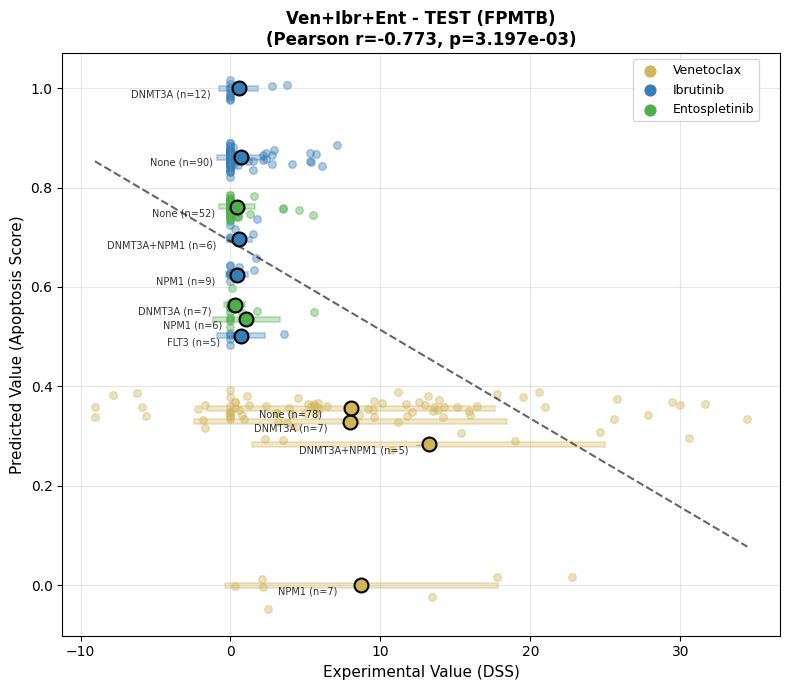

Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/prediction_vs_experimental_individual.png


In [279]:
data_df = pd.read_csv('../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv')
expanded_plot(data_df, df_long, eval_result, drug2target, use_spearman=False, save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/prediction_vs_experimental_individual.png')

# Drug combination

In [256]:
# Mutation profile × Drug combination Heatmap
# Simulate PBN on all mutation profile + drug treatment combinations

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the PBN trained on all 3 drugs
pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/pbn.txt')

# Gene classification from Palma_class.csv
gene_to_class = {
    'FLT3': 'oncogene', 'NPM1': 'TSG', 'DNMT3A': 'TSG',
    'AKT1': 'oncogene', 'BCL2': 'oncogene', 'CCND1': 'oncogene',
    'CDKN2A': 'TSG', 'CEBPA': 'TSG', 'ETV6': 'TSG', 'FBXW7': 'TSG',
    'GSK3B': 'oncogene', 'HOXA9': 'oncogene', 'MAPK1': 'oncogene',
    'MEIS1': 'oncogene', 'MYC': 'oncogene', 'SOX4': 'oncogene',
    'STAT5A': 'oncogene', 'TP53': 'TSG', 'NRAS': 'oncogene'
}

# Drug to target mapping
drug2target = {
    'Venetoclax': ['BCL2'],
    'Ibrutinib': ['BTK'], 
    'Entospletinib': ['SYK'],
}
mutation_genes = ['FLT3', 'NPM1', 'DNMT3A']

drugs = ['Venetoclax', 'Ibrutinib', 'Entospletinib']

# Generate all mutation profile combinations (2^3 = 8 profiles)
all_mutation_profiles = []
for r in range(len(mutation_genes) + 1):
    for combo in itertools.combinations(mutation_genes, r):
        all_mutation_profiles.append(set(combo))

# Generate all drug combinations (2^3 = 8 conditions including no drug)
all_drug_combos = []
for r in range(len(drugs) + 1):
    for combo in itertools.combinations(drugs, r):
        all_drug_combos.append(list(combo))

print(f"Mutation profiles ({len(all_mutation_profiles)}):")
for p in all_mutation_profiles:
    label = '+'.join(sorted(p)) if p else 'None'
    print(f"  {label}")

print(f"\nDrug combinations ({len(all_drug_combos)}):")
for d in all_drug_combos:
    label = '+'.join(d) if d else 'No drug'
    print(f"  {label}")

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Mutation profiles (8):
  None
  FLT3
  NPM1
  DNMT3A
  FLT3+NPM1
  DNMT3A+FLT3
  DNMT3A+NPM1
  DNMT3A+FLT3+NPM1

Drug combinations (8):
  No drug
  Venetoclax
  Ibrutinib
  Entospletinib
  Venetoclax+Ibrutinib
  Venetoclax+Entospletinib
  Ibrutinib+Entospletinib
  Venetoclax+Ibrutinib+Entospletinib


In [257]:
# Run simulation for all mutation profiles × drug combinations
np.random.seed(9)

# Store results: columns = mutation profiles, rows = drug conditions
results_matrix = []
condition_labels = []  # Row labels (drug conditions)
profile_labels = []    # Column labels (mutation profiles)

# Create profile labels
for profile in all_mutation_profiles:
    label = '+'.join(sorted(profile)) if profile else 'None'
    profile_labels.append(label)

# Simulation for each drug condition
for drug_combo in all_drug_combos:
    drug_label = '+'.join(drug_combo) if drug_combo else 'No drug'
    condition_labels.append(drug_label)
    
    # Get drug targets for this combination
    drug_targets = []
    for drug in drug_combo:
        drug_targets.extend(drug2target.get(drug, []))
    
    row_results = []
    
    # For each mutation profile
    for profile in all_mutation_profiles:
        # Classify mutation genes
        oncogenes_in_profile = []
        tsgs_in_profile = []
        
        for gene in profile:
            gene_class = gene_to_class.get(gene, 'unknown')
            if gene_class == 'oncogene':
                oncogenes_in_profile.append(gene)
            elif gene_class == 'TSG':
                tsgs_in_profile.append(gene)
        
        # Oncogenes → Stimuli (activate, fix to 1)
        stimuli = oncogenes_in_profile if oncogenes_in_profile else []
        
        # TSGs + Drug targets → Inhibitors (knockdown, fix to 0)
        inhibitors = list(set(tsgs_in_profile + drug_targets))
        
        # Filter to only genes that exist in the network
        stimuli = [g for g in stimuli if g in pbn.nodeDict]
        inhibitors = [g for g in inhibitors if g in pbn.nodeDict]
        
        # Run steady state simulation
        calc = BNMPy.SteadyStateCalculator(pbn)
        calc.set_experimental_conditions(
            stimuli=stimuli if stimuli else None,
            inhibitors=inhibitors if inhibitors else None
        )
        
        steady_state = calc.compute_steady_state(
            method='tsmc',
            epsilon=0.05,
            r=0.1,
            s=0.85,
            p_mir=0.01,
            freeze_constant=True
        )
        
        # Calculate phenotype score (APOPTOSIS)
        # Using formula: - AKT1 - BCL2 + CDKN2A + GSK3B - MAPK1 - MEIS1 - STAT5A + TP53
        phenotype_genes = {
            'AKT1': -1, 'BCL2': -1, 'CDKN2A': 1, 'GSK3B': 1, 
            'MAPK1': -1, 'MEIS1': -1, 'STAT5A': -1, 'TP53': 1
        }
        
        score = 0
        for gene, coef in phenotype_genes.items():
            if gene in pbn.nodeDict:
                score += coef * steady_state[pbn.nodeDict[gene]]
        
        row_results.append(score)
        calc.reset_network_conditions()
    
    results_matrix.append(row_results)
    print(f"Completed: {drug_label}")

# Create DataFrame
results_df = pd.DataFrame(results_matrix, index=condition_labels, columns=profile_labels)
print("\n=== Simulation Results (APOPTOSIS score) ===")
print(results_df.round(3))

Completed: No drug
Completed: Venetoclax
Completed: Ibrutinib
Completed: Entospletinib
Completed: Venetoclax+Ibrutinib
Completed: Venetoclax+Entospletinib
Completed: Ibrutinib+Entospletinib
Completed: Venetoclax+Ibrutinib+Entospletinib

=== Simulation Results (APOPTOSIS score) ===
                                     None   FLT3   NPM1  DNMT3A  FLT3+NPM1  \
No drug                            -1.405 -1.460 -2.018  -1.066     -0.880   
Venetoclax                         -1.300 -0.509 -0.781  -1.050     -0.202   
Ibrutinib                          -1.445 -0.978 -1.200  -1.770     -0.546   
Entospletinib                      -3.790 -1.177 -3.529  -0.976     -1.741   
Venetoclax+Ibrutinib               -0.715 -0.548 -0.320  -0.730      0.180   
Venetoclax+Entospletinib           -1.047 -0.849 -0.684  -1.050     -0.489   
Ibrutinib+Entospletinib            -1.407 -1.160 -1.060  -1.770     -0.890   
Venetoclax+Ibrutinib+Entospletinib -0.640 -0.500 -0.690  -0.570      0.190   

               

/var/folders/3q/mq6dnx4n3xz43nfx45y0by480000gn/T/ipykernel_36894/973875139.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


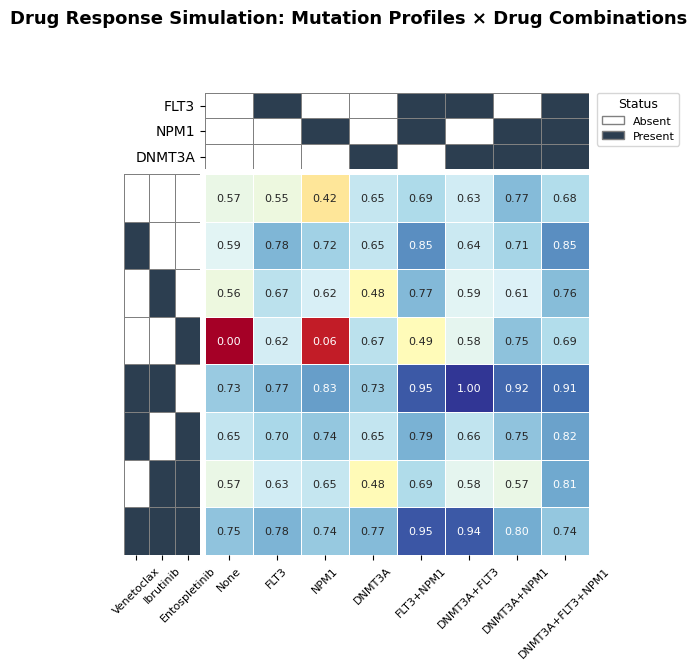


Heatmap saved to: mutation_drug_heatmap.png


In [284]:
# Create annotated heatmap with mutation profiles and drug conditions

# Create binary matrices for annotation
# Mutation profile annotation (which genes are mutated in each profile)
mutation_annotation = pd.DataFrame(0, index=mutation_genes, columns=profile_labels)
for i, profile in enumerate(all_mutation_profiles):
    for gene in profile:
        mutation_annotation.loc[gene, profile_labels[i]] = 1

# Drug condition annotation (which drugs are used in each condition)
drug_annotation = pd.DataFrame(0, index=drugs, columns=condition_labels)
for i, drug_combo in enumerate(all_drug_combos):
    for drug in drug_combo:
        drug_annotation.loc[drug, condition_labels[i]] = 1

# Normalize results for better visualization
results_normalized = results_df.copy()

# Create figure with subplots
fig = plt.figure(figsize=(6, 6))

# Define grid for subplots
gs = fig.add_gridspec(2, 2, width_ratios=[0.2, 1], height_ratios=[0.2, 1],
                      hspace=0.02, wspace=0.02)

# Subplot positions
ax_mut = fig.add_subplot(gs[0, 1])      # Mutation annotation (top)
ax_drug = fig.add_subplot(gs[1, 0])     # Drug annotation (left)
ax_main = fig.add_subplot(gs[1, 1])     # Main heatmap

# Color settings
bw = ListedColormap(['white', '#2C3E50'])  # dark blue-gray for active
heat = sns.color_palette('RdYlBu', as_cmap=True)  # high=blue (good), low=red (bad)

# 1. Mutation annotation heatmap (top) - transpose so rows=genes, cols=profiles
sns.heatmap(mutation_annotation, cmap=bw, ax=ax_mut, cbar=False,
            linewidths=0.5, linecolor='gray',
            xticklabels=False, yticklabels=True)
ax_mut.set_ylabel('')
# ax_mut.set_title('Mutation Profiles', fontsize=12, fontweight='bold')
ax_mut.tick_params(axis='y', rotation=0)

# 2. Drug annotation heatmap (left) - transpose so rows=drugs, cols=conditions
drug_annotation_T = drug_annotation.T  # Transpose: rows=conditions, cols=drugs
sns.heatmap(drug_annotation_T, cmap=bw, ax=ax_drug, cbar=False,
            linewidths=0.5, linecolor='gray',
            xticklabels=True, yticklabels=False)
ax_drug.set_xlabel('')
ax_drug.set_ylabel('')
ax_drug.tick_params(axis='x', rotation=45, labelsize=8)
ax_drug.tick_params(axis='y', rotation=0, labelsize=8)

# 3. Main heatmap (APOPTOSIS scores)
vmin, vmax = results_df.values.min(), results_df.values.max()
# normalize the heatmap
results_df_normalized = (results_df - vmin) / (vmax - vmin)
sns.heatmap(results_df_normalized, cmap=heat, ax=ax_main, cbar=False,
            linewidths=0.5, linecolor='white',
            annot=True, fmt='.2f', annot_kws={'size': 8},
            xticklabels=True, yticklabels=False,
            cbar_kws={'label': 'APOPTOSIS Score'})
# ax_main.set_xlabel('Mutation Profile', fontsize=11)
ax_main.set_ylabel('')
ax_main.tick_params(axis='x', rotation=45, labelsize=8)

# Add legend for binary annotation
legend_elements = [
    plt.Rectangle((0,0), 1, 1, facecolor='white', edgecolor='gray', label='Absent'),
    plt.Rectangle((0,0), 1, 1, facecolor='#2C3E50', edgecolor='gray', label='Present')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.06, 0.89),
           title='Status', fontsize=8, title_fontsize=9)

plt.suptitle('Drug Response Simulation: Mutation Profiles × Drug Combinations',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('mutation_drug_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved to: mutation_drug_heatmap.png")

In [259]:
# Summary analysis: Best drug combinations for each mutation profile

print("=" * 60)
print("SUMMARY: Best Drug Combinations by Mutation Profile")
print("=" * 60)

# Calculate drug effect (difference from no drug baseline)
baseline = results_df.loc['No drug']
drug_effect_df = results_df.subtract(baseline, axis=1)

print("\n--- Drug Effect (APOPTOSIS score change from No drug) ---")
print(drug_effect_df.round(3))

print("\n--- Best Drug for Each Mutation Profile ---")
for profile in profile_labels:
    profile_effects = drug_effect_df[profile].drop('No drug')
    best_drug = profile_effects.idxmax()
    best_effect = profile_effects.max()
    baseline_score = baseline[profile]
    print(f"\n{profile}:")
    print(f"  Baseline (No drug): {baseline_score:.3f}")
    print(f"  Best treatment: {best_drug} (+{best_effect:.3f})")
    print(f"  Top 3 treatments:")
    top3 = profile_effects.nlargest(3)
    for drug, effect in top3.items():
        print(f"    - {drug}: +{effect:.3f} (total: {baseline_score + effect:.3f})")

# Overall ranking
print("\n" + "=" * 60)
print("OVERALL DRUG RANKING (Average effect across all profiles)")
print("=" * 60)
avg_effects = drug_effect_df.drop('No drug').mean(axis=1).sort_values(ascending=False)
for drug, effect in avg_effects.items():
    print(f"  {drug}: +{effect:.3f}")

# Save results to CSV
results_df.to_csv('mutation_drug_simulation_results.csv')
drug_effect_df.to_csv('mutation_drug_effects.csv')
print("\n\nResults saved to:")
print("  - mutation_drug_simulation_results.csv")
print("  - mutation_drug_effects.csv")

SUMMARY: Best Drug Combinations by Mutation Profile

--- Drug Effect (APOPTOSIS score change from No drug) ---
                                     None   FLT3   NPM1  DNMT3A  FLT3+NPM1  \
No drug                             0.000  0.000  0.000   0.000      0.000   
Venetoclax                          0.105  0.951  1.237   0.016      0.678   
Ibrutinib                          -0.040  0.482  0.818  -0.704      0.334   
Entospletinib                      -2.385  0.283 -1.511   0.089     -0.861   
Venetoclax+Ibrutinib                0.689  0.912  1.698   0.336      1.060   
Venetoclax+Entospletinib            0.358  0.611  1.334   0.016      0.391   
Ibrutinib+Entospletinib            -0.002  0.300  0.958  -0.704     -0.010   
Venetoclax+Ibrutinib+Entospletinib  0.765  0.960  1.328   0.496      1.070   

                                    DNMT3A+FLT3  DNMT3A+NPM1  DNMT3A+FLT3+NPM1  
No drug                                   0.000        0.000             0.000  
Venetoclax              

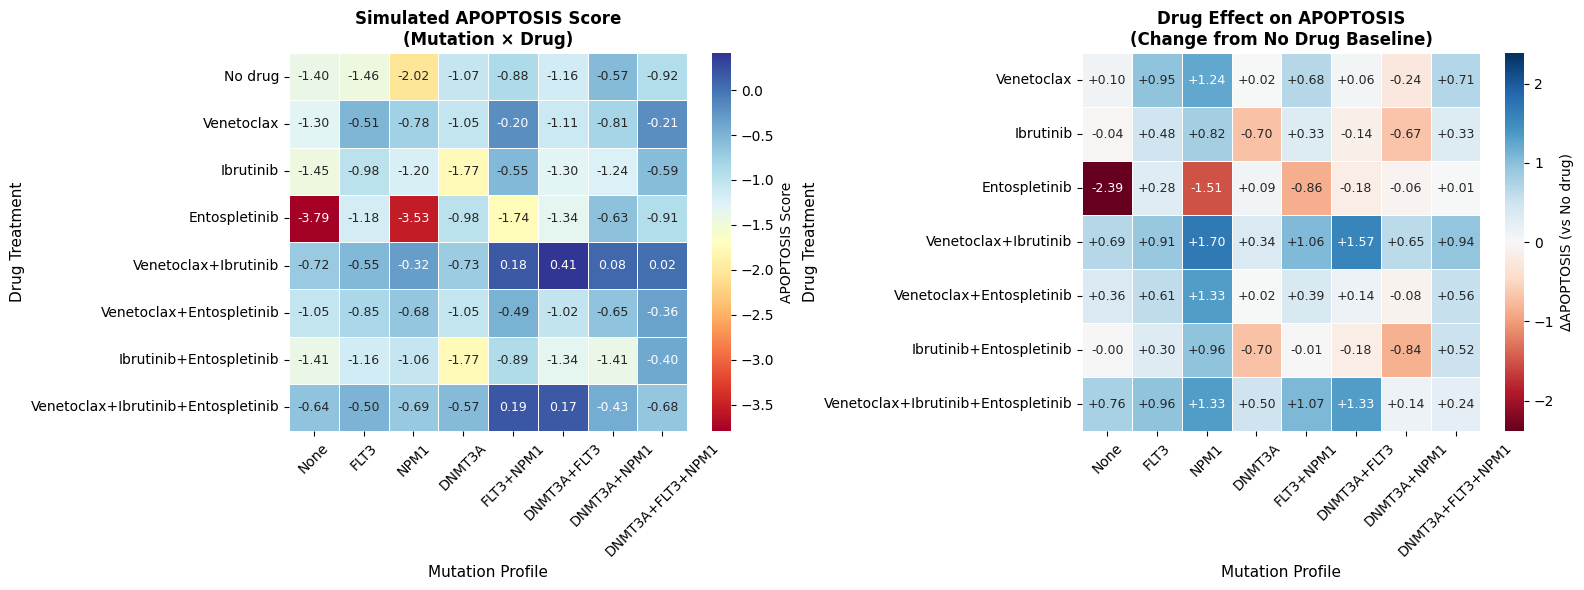


Heatmap saved to: drug_effect_heatmap.png

Interpretation:
  - RED values indicate INCREASED apoptosis (beneficial drug effect)
  - BLUE values indicate DECREASED apoptosis (harmful or no effect)
  - Higher magnitude = stronger effect


In [260]:
# Simplified heatmap: Drug Effect on APOPTOSIS score

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Absolute APOPTOSIS scores
ax1 = axes[0]
sns.heatmap(results_df, cmap='RdYlBu', ax=ax1, cbar=True,
            linewidths=0.5, linecolor='white',
            annot=True, fmt='.2f', annot_kws={'size': 9},
            cbar_kws={'label': 'APOPTOSIS Score'})
ax1.set_title('Simulated APOPTOSIS Score\n(Mutation × Drug)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Mutation Profile', fontsize=11)
ax1.set_ylabel('Drug Treatment', fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# 2. Drug effect (change from baseline)
ax2 = axes[1]
# Remove 'No drug' row for effect heatmap
effect_no_baseline = drug_effect_df.drop('No drug')

# Center the colormap at 0
max_abs = max(abs(effect_no_baseline.values.min()), abs(effect_no_baseline.values.max()))
sns.heatmap(effect_no_baseline, cmap='RdBu', ax=ax2, cbar=True,
            linewidths=0.5, linecolor='white',
            annot=True, fmt='+.2f', annot_kws={'size': 9},
            center=0, vmin=-max_abs, vmax=max_abs,
            cbar_kws={'label': 'ΔAPOPTOSIS (vs No drug)'})
ax2.set_title('Drug Effect on APOPTOSIS\n(Change from No Drug Baseline)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Mutation Profile', fontsize=11)
ax2.set_ylabel('Drug Treatment', fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('drug_effect_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved to: drug_effect_heatmap.png")
print("\nInterpretation:")
print("  - RED values indicate INCREASED apoptosis (beneficial drug effect)")
print("  - BLUE values indicate DECREASED apoptosis (harmful or no effect)")
print("  - Higher magnitude = stronger effect")
